# Python translation of CO$_2$ Flux Driver diagnostics (Lauderdale et al., 2016)

In [1]:
import cmocean    as cm
import matplotlib as mp
import numpy      as np
import xarray     as xr

import mitgcm_tools
import warnings
import xgcm

from matplotlib import pyplot    as plt
from matplotlib import animation as pla
#plt.rcParams.update({'font.size': 15})
plt.rcParams['animation.html'] = 'html5'

def label_axes(axarray,ignore=None,label_columns=False):
    import string      as st
    m=0
    
    if label_columns:
        axarray=np.transpose(axarray)
    
    for n, ax in enumerate(axarray.flat):
        if ignore is not None and n in ignore:
            m+=1
            continue
        else:
            ax.text(-0.1, 1.05, st.ascii_uppercase[n-m], transform=ax.transAxes, 
                    size=20, weight='bold')

## Methods, constants, and conversions

In [2]:
kave_method='arb_depth'
kave=55 # arbitrary depth in metres

cp = 3985.0 # Heat capacity J kg-1 K-1
KDOPRemin=1/(6*30*86400) # six months in s-1
seconds_per_year=360.*86400
rhoconst=1024.5
perl_2_perkg=1000/rhoconst # e.g. mol l-1 * 1000 l m-3 * 1/rho m3 kg-1 -> mol kg-1
perm3_2_perl = 1.0/1000 #e.g. mol m-3 * 1/1000 m3 l-1 -> mol l-1
molperm3_2_umolperkg=1e6/rhoconst
umolperkgmpers_2_molperm2peryr = rhoconst*seconds_per_year*1e-6

# set Redfield ratios for organic matter
Rcn   = 117/16
Rcp   = 117
Rpo   =-1/170
Rno   =-16/170
Rnp   = 16/1
Rcaco3= 7e-2 # Inorganic/organic carbon rain ratio
Rsip  = 15

## Load in some model data

In [3]:
path = 'model_kpp/'

grid,xgrid=mitgcm_tools.loadgrid(path+'grid.glob.nc')
grid=grid.transpose('XC','XG','YC','YG','ZC','ZG','ZL','ZR')
grid.close()

data_parms = mitgcm_tools.getparm(path+'data') 
#grid['iter'] = np.arange(data_parms['niter0'],
#                              data_parms['niter0']+data_parms['ntimesteps']+data_parms['tavefreq']/data_parms['deltatclock'],
#                              data_parms['tavefreq']/data_parms['deltatclock'])
data_pkg   = mitgcm_tools.getparm(path+'data.pkg') 

if data_pkg['usegmredi']:
    data_gmr = mitgcm_tools.getparm(path+'data.gmredi')     
    
if data_pkg['useptracers']:
    data_ptr = mitgcm_tools.getparm(path+'data.ptracers') 

    
if data_pkg['usegchem']:
    data_gch = mitgcm_tools.getparm(path+'data.gchem') 
    if data_gch['usedic']:
        data_dic = mitgcm_tools.getparm(path+'data.dic') 

if data_pkg['usekpp']:
    data_kpp = mitgcm_tools.getparm(path+'data.kpp') 
    kppdiag= mitgcm_tools.open_ncfile(path+'kppDiag.*.glob.nc',
                                            strange_axes={'Zmd000015':'ZC','Zld000015':'ZL'},grid=grid)
    kppdiag.close()

surfdiag= mitgcm_tools.open_ncfile(path+'surfDiag.*.glob.nc',
                                            strange_axes={'Zmd000001':'ZC','Zd000001':'ZL'},grid=grid)
surfdiag.close()

ocediag = mitgcm_tools.open_ncfile(path+'oceDiag.*.glob.nc',
                                            strange_axes={'Zmd000015':'ZC','Zld000015':'ZL'},grid=grid)
ocediag.close()

gmdiag = mitgcm_tools.open_ncfile(path+'oceDiag.*.glob.nc',
                                            strange_axes={'Zmd000015':'ZC','Zld000015':'ZL'},grid=grid)
gmdiag.close()

dicdiag=mitgcm_tools.open_ncfile(path+'dicDiag.*.glob.nc',
                                     strange_axes={'Zmd000015':'ZC','Zld000015':'ZL'},grid=grid)
dicdiag.close()
                                                                
dic_surfdiag=mitgcm_tools.open_ncfile(path+'dic_surfDiag.*.glob.nc',
                                            strange_axes={'Zmd000001':'ZC','Zd000001':'ZL'},grid=grid)
dic_surfdiag.close()

tave = mitgcm_tools.open_ncfile(path+'tave.*.glob.nc')
tave.close()

flxdiag = mitgcm_tools.open_ncfile(path+'flxDiag.*.glob.nc',
                                     strange_axes={'Zmd000015':'ZC','Zld000015':'ZL'},grid=grid)
dicflx  = mitgcm_tools.open_ncfile(path+'dic_flxDiag.*.glob.nc',
                                     strange_axes={'Zmd000015':'ZC','Zld000015':'ZL'},grid=grid)
alkflx  = mitgcm_tools.open_ncfile(path+'alk_flxDiag.*.glob.nc',
                                     strange_axes={'Zmd000015':'ZC','Zld000015':'ZL'},grid=grid)
po4flx  = mitgcm_tools.open_ncfile(path+'po4_flxDiag.*.glob.nc',
                                     strange_axes={'Zmd000015':'ZC','Zld000015':'ZL'},grid=grid)
dopflx  = mitgcm_tools.open_ncfile(path+'dop_flxDiag.*.glob.nc',
                                     strange_axes={'Zmd000015':'ZC','Zld000015':'ZL'},grid=grid)

# Snapshots for tendency terms
state = mitgcm_tools.open_ncfile(path+'state.*.glob.nc')
state.close()

ptracers = mitgcm_tools.open_ncfile(path+'ptracers.*.glob.nc')
ptracers.close()

dic_surfdiag['sit'] = xr.DataArray(mitgcm_tools.open_bnfile(path+data_dic['dic_silicafile'])[0:12,:,:],
                   coords=[dic_surfdiag.T.data, dic_surfdiag.YC.data, dic_surfdiag.XC], 
                   dims  =['T','YC','XC'])

# bit of a hack for pCO2 box
grid['iter']=state.iter

atm_box=mitgcm_tools.get_dicpco2(data_parms,data_dic,grid,path=path).assign_coords(T=state.T) # change iter coord to T
dpco2dt=atm_box.pco2.diff('T')/data_parms['dumpfreq']

The axes: T could not be converted
Attributes could not be added for axes: T
Coordinates added for axes: ZC
Coordinates added for axes: ZC,ZL
The axes: T could not be converted
Attributes could not be added for axes: T
Coordinates added for axes: ZL
The axes: T could not be converted
Attributes could not be added for axes: T
Coordinates added for axes: ZC
Coordinates added for axes: ZC,ZL
The axes: T could not be converted
Attributes could not be added for axes: T
Coordinates added for axes: ZC
Coordinates added for axes: ZC,ZL
The axes: T could not be converted
Attributes could not be added for axes: T
Coordinates added for axes: ZC
The axes: T could not be converted
Attributes could not be added for axes: T
Coordinates added for axes: ZL
The axes: T could not be converted
Attributes could not be added for axes: T
The axes: T could not be converted
Attributes could not be added for axes: T
Coordinates added for axes: ZC
Coordinates added for axes: ZC,ZL
The axes: T could not be conver

Now that we've loaded in the model files, we should check that everything adds up by doing surface layer budgets of temperature, salinity, Alkalinity, DIC, and phosphate. We use the advective and diffusive fluxes calculated by the model, as well as air-sea fluxes and biological activity. Tendencies are calculated as time-differences between snapshots (rather than averages). 

Grid-aware calculations are performed using `XGCM`, which handles the grid metrics like distances, areas, and volumes where necessary.

### THETA Budget 
Divergence of theta advection, diffusion, surface heat fluxes, and tendency, time averaged over a year:

#### $$\frac{\partial\theta}{\partial t}=-\nabla\cdot(\vec{u}\theta)+\nabla\cdot(\kappa\nabla\theta) - \frac{F_\theta}{\rho C_p h}$$
where $F_\theta$ is the air-sea flux of heat

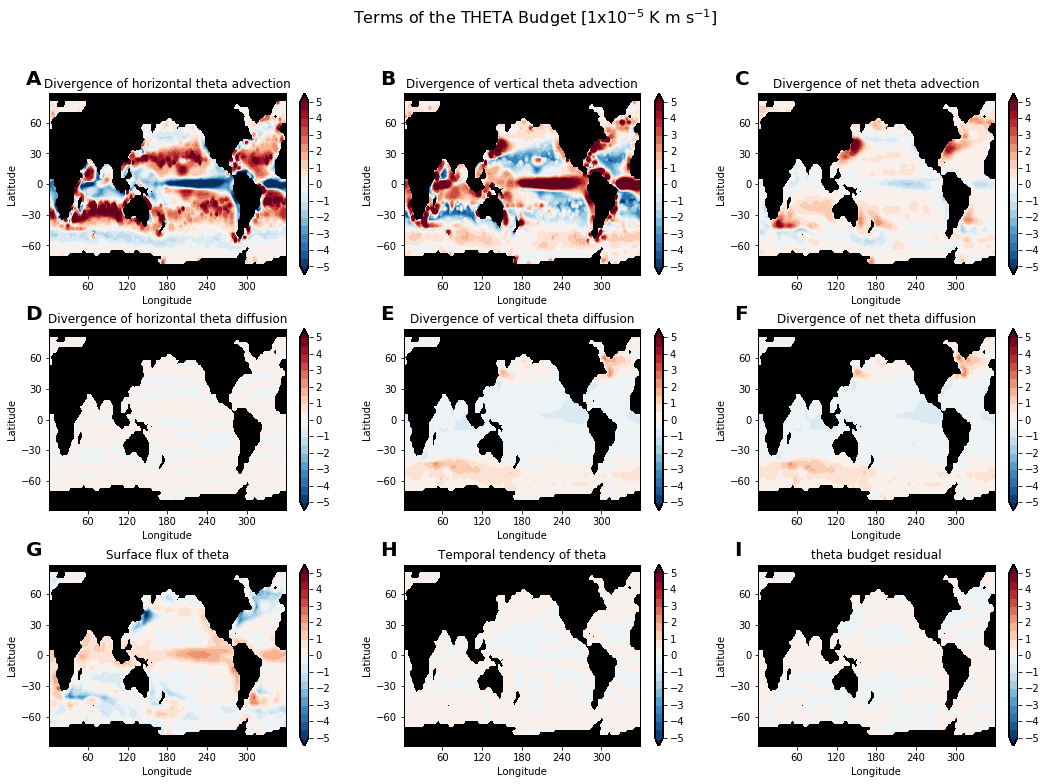

In [4]:
hdiff_ADV_th   = xgrid.diff_2d_vector({'X': flxdiag.ADVx_TH, 'Y': flxdiag.ADVy_TH}, boundary='fill')
theta_adv_horz =-(((hdiff_ADV_th['X']+hdiff_ADV_th['Y'])*grid.dzC)/grid.cvol).sel(ZC=slice(0,-kave)).sum("ZC")*grid.cmask.isel(ZC=0)
theta_adv_vert =((xgrid.diff(flxdiag.ADVr_TH+kppdiag.KPPg_TH,'Z',boundary='fill')*grid.dzC)/grid.cvol).sel(ZC=slice(0,-kave)).sum("ZC")*grid.cmask.isel(ZC=0)

hdiff_DIF_th   = xgrid.diff_2d_vector({'X': flxdiag.DFxE_TH, 'Y': flxdiag.DFyE_TH}, boundary='fill')
theta_dif_horz =-(((hdiff_DIF_th['X']+hdiff_DIF_th['Y'])*grid.dzC)/grid.cvol).sel(ZC=slice(0,-kave)).sum("ZC")*grid.cmask.isel(ZC=0)
theta_dif_vert =((xgrid.diff(flxdiag.DFrE_TH+flxdiag.DFrI_TH,'Z',boundary='fill')*grid.dzC)/grid.cvol).sel(ZC=slice(0,-kave)).sum("ZC")*grid.cmask.isel(ZC=0)

theta_surf_flux= surfdiag.TFLUX*grid.cmask.isel(ZC=0)/(rhoconst*cp) # W/m2 to K.m/s
dthetadt      = ((state.Temp.diff('T')*grid.dzC).sel(ZC=slice(0,-kave)).sum("ZC")/data_parms['dumpfreq'])*grid.cmask.isel(ZC=0)

# The budget residual
theta_tot_budget = theta_adv_horz + theta_adv_vert + theta_dif_horz + theta_dif_vert + dthetadt + theta_surf_flux

with warnings.catch_warnings(): # these lines just make sure that the warnings about "mean of empty slice" dont clutter your notebook
    warnings.simplefilter("ignore",category=RuntimeWarning)
    f0,f0ax=plt.subplots(figsize=(18, 12),ncols=3,nrows=3)
    f0.patch.set_facecolor('None')
    f0cax = f0ax.copy()
    f0cbar= f0ax.copy()
    tfac=1e5
    ctargs={"levels":np.arange(-5,5.5,0.5),"cmap":"RdBu_r","extend":"both"}
    cbargs={"ticks" :np.arange(-5,6,1),"extend":"both"}
    axargs={"xlabel":"Longitude","ylabel":"Latitude","xticks":np.arange(0,420,60),"yticks":np.arange(-90,120,30),"facecolor":"black"}
    
    f0ax  [0,0].set(title="Divergence of horizontal theta advection",**axargs)
    f0cax [0,0]=f0ax[0,0].contourf(grid.XC,grid.YC,tfac*theta_adv_horz.mean("T",skipna=True),**ctargs)
    for a in f0ax[0,0].collections:
        a.set_edgecolor("face")
    f0cbar[0,0]=f0.colorbar(f0cax[0,0],ax=f0ax[0,0],**cbargs)
    f0cbar[0,0].solids.set_edgecolor("face")
    f0ax  [0,1].set(title="Divergence of vertical theta advection",**axargs)
    f0cax [0,1]=f0ax[0,1].contourf(grid.XC,grid.YC,tfac*theta_adv_vert.mean("T",skipna=True),**ctargs)
    for a in f0ax[0,1].collections:
        a.set_edgecolor("face")
    f0cbar[0,1]=f0.colorbar(f0cax[0,1],ax=f0ax[0,1],**cbargs)
    f0cbar[0,1].solids.set_edgecolor("face")
    f0ax  [0,2].set(title="Divergence of net theta advection",**axargs)
    f0cax [0,2]=f0ax[0,2].contourf(grid.XC,grid.YC,tfac*(theta_adv_horz+theta_adv_vert).mean("T",skipna=True),**ctargs)
    for a in f0ax[0,2].collections:
        a.set_edgecolor("face")
    f0cbar[0,2]=f0.colorbar(f0cax[0,2],ax=f0ax[0,2],**cbargs)
    f0cbar[0,2].solids.set_edgecolor("face")
    f0ax  [1,0].set(title="Divergence of horizontal theta diffusion",**axargs)
    f0cax [1,0]=f0ax[1,0].contourf(grid.XC,grid.YC,tfac*theta_dif_horz.mean("T",skipna=True),**ctargs)
    for a in f0ax[1,0].collections:
        a.set_edgecolor("face")
    f0cbar[1,0]=f0.colorbar(f0cax[1,0],ax=f0ax[1,0],**cbargs)
    f0cbar[1,0].solids.set_edgecolor("face")
    f0ax  [1,1].set(title="Divergence of vertical theta diffusion",**axargs)
    f0cax [1,1]=f0ax[1,1].contourf(grid.XC,grid.YC,tfac*theta_dif_vert.mean("T",skipna=True),**ctargs)
    for a in f0ax[1,1].collections:
        a.set_edgecolor("face")
    f0cbar[1,1]=f0.colorbar(f0cax[1,1],ax=f0ax[1,1],**cbargs)
    f0cbar[1,1].solids.set_edgecolor("face")
    f0ax  [1,2].set(title="Divergence of net theta diffusion",**axargs)
    f0cax [1,2]=f0ax[1,2].contourf(grid.XC,grid.YC,tfac*(theta_dif_horz+theta_dif_vert).mean("T",skipna=True),**ctargs)
    for a in f0ax[1,2].collections:
        a.set_edgecolor("face")
    f0cbar[1,2]=f0.colorbar(f0cax[1,2],ax=f0ax[1,2],**cbargs)
    f0cbar[1,2].solids.set_edgecolor("face")
    f0ax  [2,0].set(title="Surface flux of theta",**axargs)
    f0cax [2,0]=f0ax[2,0].contourf(grid.XC,grid.YC,tfac*theta_surf_flux.mean("T",skipna=True),**ctargs)
    for a in f0ax[2,0].collections:
        a.set_edgecolor("face")
    f0cbar[2,0]=f0.colorbar(f0cax[2,0],ax=f0ax[2,0],**cbargs)
    f0cbar[2,0].solids.set_edgecolor("face")
    f0ax  [2,1].set(title="Temporal tendency of theta",**axargs)
    f0cax [2,1]=f0ax[2,1].contourf(grid.XC,grid.YC,tfac*dthetadt.mean("T",skipna=True), **ctargs)
    for a in f0ax[2,1].collections:
        a.set_edgecolor("face")
    f0cbar[2,1]=f0.colorbar(f0cax[2,1],ax=f0ax[2,1],**cbargs)
    f0cbar[2,1].solids.set_edgecolor("face")
    f0ax  [2,2].set(title="theta budget residual",**axargs)
    f0cax [2,2]=f0ax[2,2].contourf(grid.XC,grid.YC,tfac*theta_tot_budget.mean("T",skipna=True),**ctargs)
    for a in f0ax[2,2].collections:
        a.set_edgecolor("face")
    f0cbar[2,2]=f0.colorbar(f0cax[2,2],ax=f0ax[2,2],**cbargs)
    f0cbar[2,2].solids.set_edgecolor("face")
    # Can adjust the subplot size
    f0.subplots_adjust(hspace=0.3) 
    f0.suptitle("Terms of the THETA Budget [1x10$^{-5}$ K m s$^{-1}$]",fontsize=16)
    # add subplot labels (a,b,c,d, etc)
    label_axes(f0ax)


### SALT/Salinity budget
Divergence of salinity advection, diffusion, surface freshwater fluxes, and tendency, time averaged over a year:

#### $$\frac{\partial S}{\partial t}=-\nabla\cdot(\vec{u}S)+\nabla\cdot(\kappa\nabla S) - \frac{\overline{S}F_{fw}}{\rho h}$$
where $F_{fw}$ is the flux of freshwater by net precipitation or evaporation.

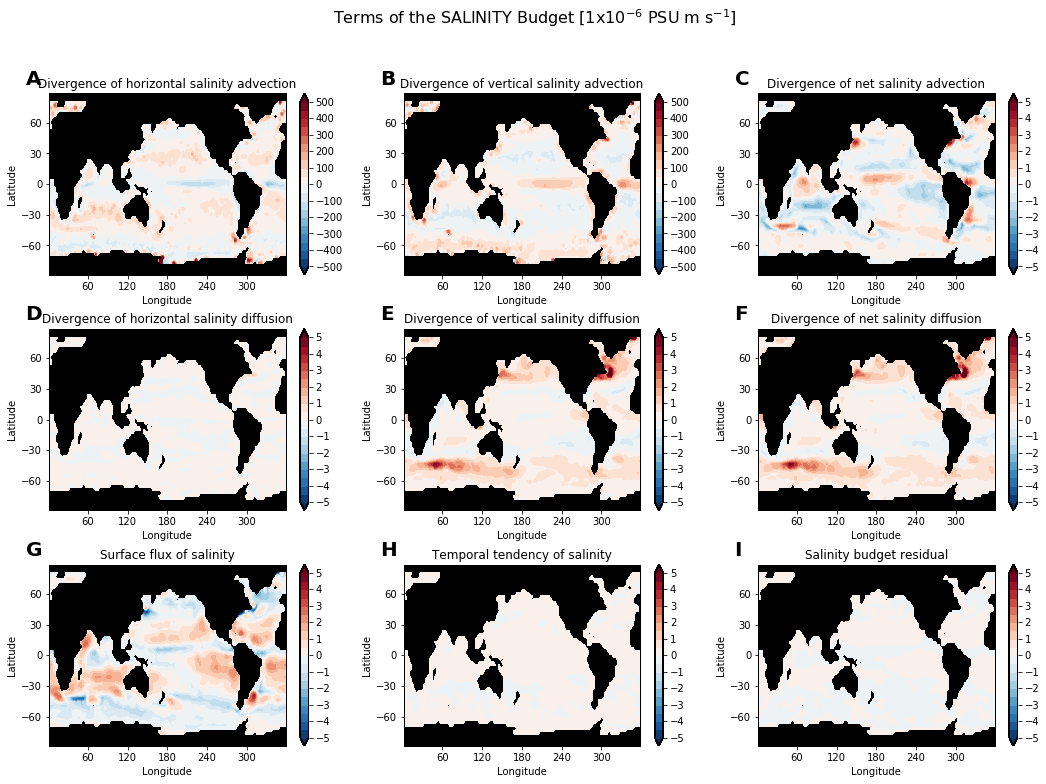

In [ ]:
hdiff_ADV_slt   = xgrid.diff_2d_vector({'X': flxdiag.ADVx_SLT, 'Y': flxdiag.ADVy_SLT}, boundary='fill')
salt_adv_horz =-(((hdiff_ADV_slt['X']+hdiff_ADV_slt['Y'])*grid.dzC)/grid.cvol).sel(ZC=slice(0,-kave)).sum("ZC")*grid.cmask.isel(ZC=0)
salt_adv_vert =((xgrid.diff(flxdiag.ADVr_SLT+kppdiag.KPPg_SLT,'Z',boundary='fill')*grid.dzC)/grid.cvol).sel(ZC=slice(0,-kave)).sum("ZC")*grid.cmask.isel(ZC=0)

hdiff_DIF_slt   = xgrid.diff_2d_vector({'X': flxdiag.DFxE_SLT, 'Y': flxdiag.DFyE_SLT}, boundary='fill')
salt_dif_horz =-(((hdiff_DIF_slt['X']+hdiff_DIF_slt['Y'])*grid.dzC)/grid.cvol).sel(ZC=slice(0,-kave)).sum("ZC")*grid.cmask.isel(ZC=0)
salt_dif_vert =((xgrid.diff(flxdiag.DFrE_SLT+flxdiag.DFrI_SLT,'Z',boundary='fill')*grid.dzC)/grid.cvol).sel(ZC=slice(0,-kave)).sum("ZC")*grid.cmask.isel(ZC=0)

salt_surf_flux= surfdiag.SFLUX*grid.cmask.isel(ZC=0)/(rhoconst) # g m-2 s-1 * m3 kg-1 => PSU m s-1
dsaltdt      = ((state.S.diff('T')*grid.dzC).sel(ZC=slice(0,-kave)).sum("ZC")/data_parms['dumpfreq'])*grid.cmask.isel(ZC=0)

# The budget residual
salt_tot_budget = salt_adv_horz + salt_adv_vert + salt_dif_horz + salt_dif_vert + dsaltdt + salt_surf_flux

with warnings.catch_warnings(): # these lines just make sure that the warnings about "mean of empty slice" dont clutter your notebook
    warnings.simplefilter("ignore",category=RuntimeWarning)
    f1,f1ax=plt.subplots(figsize=(18, 12),ncols=3,nrows=3)
    f1.patch.set_facecolor('None')
    f1cax = f1ax.copy()
    f1cbar= f1ax.copy()
    sfac=1e6
    ctargs={"levels":np.arange(-5,5.5,0.5),"cmap":"RdBu_r","extend":"both"}
    ctarg2={"levels":np.arange(-500,550,50),"cmap":"RdBu_r","extend":"both"}
    cbargs={"ticks" :np.arange(-5,6,1),"extend":"both"}
    cbarg2={"ticks" :np.arange(-500,600,100),"extend":"both"}
    axargs={"xlabel":"Longitude","ylabel":"Latitude","xticks":np.arange(0,420,60),"yticks":np.arange(-90,120,30),"facecolor":"black"}

    f1ax  [0,0].set(title="Divergence of horizontal salinity advection",**axargs)
    f1cax [0,0]=f1ax[0,0].contourf(grid.XC,grid.YC,sfac*salt_adv_horz.mean("T",skipna=True),**ctarg2)
    for a in f1ax[0,0].collections:
        a.set_edgecolor("face")
    f1cbar[0,0]=f1.colorbar(f1cax[0,0],ax=f1ax[0,0],**cbarg2)
    f1cbar[0,0].solids.set_edgecolor("face")
    f1ax  [0,1].set(title="Divergence of vertical salinity advection",**axargs)                
    f1cax [0,1]=f1ax[0,1].contourf(grid.XC,grid.YC,sfac*salt_adv_vert.mean("T",skipna=True),**ctarg2)
    for a in f1ax[0,1].collections:
        a.set_edgecolor("face")
    f1cbar[0,1]=f1.colorbar(f1cax[0,1],ax=f1ax[0,1],**cbarg2)
    f1cbar[0,1].solids.set_edgecolor("face")
    f1ax  [0,2].set(title="Divergence of net salinity advection",**axargs)             
    f1cax [0,2]=f1ax[0,2].contourf(grid.XC,grid.YC,sfac*(salt_adv_horz+salt_adv_vert).mean("T",skipna=True),**ctargs)
    for a in f1ax[0,2].collections:
        a.set_edgecolor("face")
    f1cbar[0,2]=f1.colorbar(f1cax[0,2],ax=f1ax[0,2],**cbargs)
    f1cbar[0,2].solids.set_edgecolor("face")
    f1ax  [1,0].set(title="Divergence of horizontal salinity diffusion",**axargs)                     
    f1cax [1,0]=f1ax[1,0].contourf(grid.XC,grid.YC,sfac*salt_dif_horz.mean("T",skipna=True),**ctargs)
    for a in f1ax[1,0].collections:
        a.set_edgecolor("face")
    f1cbar[1,0]=f1.colorbar(f1cax[1,0],ax=f1ax[1,0],**cbargs)
    f1cbar[1,0].solids.set_edgecolor("face")
    f1ax  [1,1].set(title="Divergence of vertical salinity diffusion",**axargs)                     
    f1cax [1,1]=f1ax[1,1].contourf(grid.XC,grid.YC,sfac*salt_dif_vert.mean("T",skipna=True),**ctargs)
    for a in f1ax[1,1].collections:
        a.set_edgecolor("face")
    f1cbar[1,1]=f1.colorbar(f1cax[1,1],ax=f1ax[1,1],**cbargs)
    f1cbar[1,1].solids.set_edgecolor("face")
    f1ax  [1,2].set(title="Divergence of net salinity diffusion",**axargs)                     
    f1cax [1,2]=f1ax[1,2].contourf(grid.XC,grid.YC,sfac*(salt_dif_horz+salt_dif_vert).mean("T",skipna=True),**ctargs)
    for a in f1ax[1,2].collections:
        a.set_edgecolor("face")
    f1cbar[1,2]=f1.colorbar(f1cax[1,2],ax=f1ax[1,2],**cbargs)
    f1cbar[1,2].solids.set_edgecolor("face")
    f1ax  [2,0].set(title="Surface flux of salinity",**axargs)                     
    f1cax [2,0]=f1ax[2,0].contourf(grid.XC,grid.YC,sfac*salt_surf_flux.mean("T",skipna=True),**ctargs)
    for a in f1ax[2,0].collections:
        a.set_edgecolor("face")
    f1cbar[2,0]=f1.colorbar(f1cax[2,0],ax=f1ax[2,0],**cbargs)
    f1cbar[2,0].solids.set_edgecolor("face")
    f1ax  [2,1].set(title="Temporal tendency of salinity",**axargs)                     
    f1cax [2,1]=f1ax[2,1].contourf(grid.XC,grid.YC,sfac*dsaltdt.mean("T",skipna=True),**ctargs)
    for a in f1ax[2,1].collections:
        a.set_edgecolor("face")
    f1cbar[2,1]=f1.colorbar(f1cax[2,1],ax=f1ax[2,1],**cbargs)
    f1cbar[2,1].solids.set_edgecolor("face")
    f1ax  [2,2].set(title="Salinity budget residual",**axargs)                     
    f1cax [2,2]=f1ax[2,2].contourf(grid.XC,grid.YC,sfac*salt_tot_budget.mean("T",skipna=True),**ctargs)
    for a in f1ax[2,2].collections:
        a.set_edgecolor("face")
    f1cbar[2,2]=f1.colorbar(f1cax[2,2],ax=f1ax[2,2],**cbargs)
    f1cbar[2,2].solids.set_edgecolor("face")
                     
    # Can adjust the subplot size
    f1.subplots_adjust(hspace=0.3) 
    f1.suptitle("Terms of the SALINITY Budget [1x10$^{-6}$ PSU m s$^{-1}$]",fontsize=16)
    # add subplot labels (a,b,c,d, etc)
    label_axes(f1ax)


### ALKALINITY Budget
Divergence of alkalinty advection, diffusion, surface freshwater fluxes, biological activity and tendency, time averaged over a year:

#### $$\frac{\partial A_T}{\partial t}=-\nabla\cdot(\vec{u} A_T)+\nabla\cdot(\kappa\nabla A_T) - \frac{\overline{A_T}F_{fw}}{\rho  h} - 2S_{CaCO_3} - R_{N:P}S_{bio}$$
where $2S_{CaCO_3}$ is the effect of carbonate precipitation/dissolution and $R_{N:P}S_{bio}$ is the change in Alkalinity due to consumption/remineralization of charged nitrate ions.

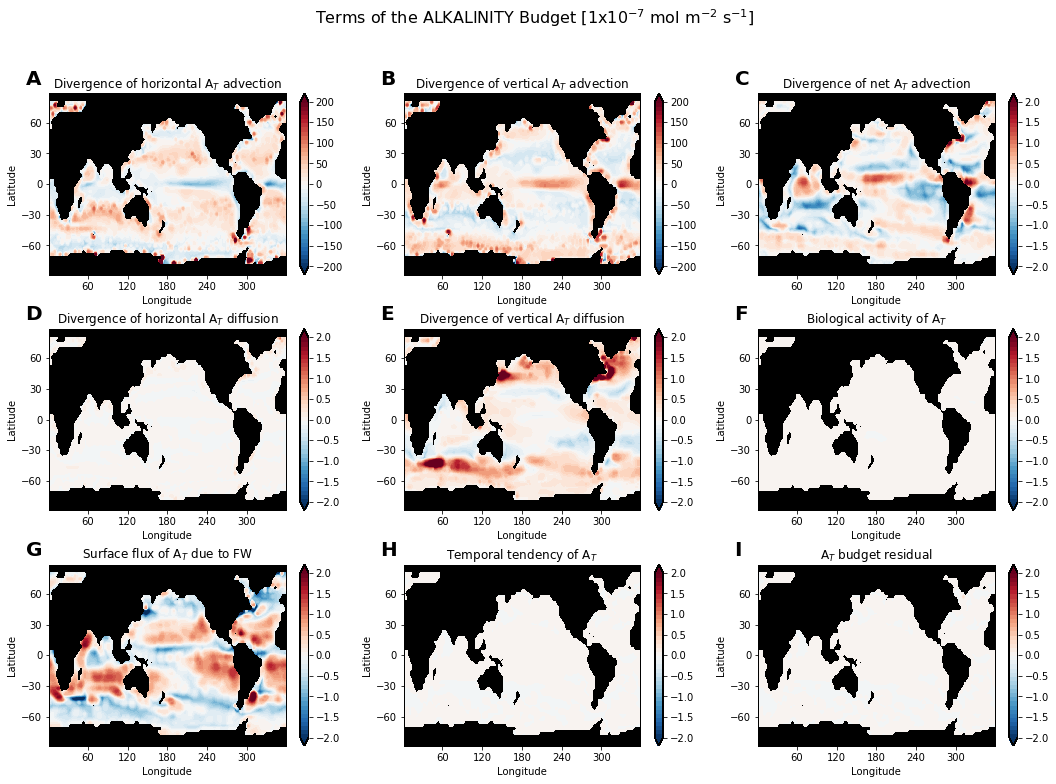

In [ ]:
hdiff_ADV_alk   = xgrid.diff_2d_vector({'X': alkflx.ADVxTr02, 'Y': alkflx.ADVyTr02}, boundary='fill')
alk_adv_horz =-(((hdiff_ADV_alk['X']+hdiff_ADV_alk['Y'])*grid.dzC)/grid.cvol).sel(ZC=slice(0,-kave)).sum("ZC")*grid.cmask.isel(ZC=0)
alk_adv_vert =((xgrid.diff(alkflx.ADVrTr02+kppdiag.KPPgTr02,'Z',boundary='fill')*grid.dzC)/grid.cvol).sel(ZC=slice(0,-kave)).sum("ZC")*grid.cmask.isel(ZC=0)

hdiff_DIF_alk   = xgrid.diff_2d_vector({'X': alkflx.DFxETr02, 'Y': alkflx.DFyETr02}, boundary='fill')
alk_dif_horz =-(((hdiff_DIF_alk['X']+hdiff_DIF_alk['Y'])*grid.dzC)/grid.cvol).sel(ZC=slice(0,-kave)).sum("ZC")*grid.cmask.isel(ZC=0)
alk_dif_vert =((xgrid.diff(alkflx.DFrETr02+alkflx.DFrITr02,'Z',boundary='fill')*grid.dzC)/grid.cvol).sel(ZC=slice(0,-kave)).sum("ZC")*grid.cmask.isel(ZC=0)

# Calculate alkalinity "virtual flux" using salt flux and surface average ALK and S ratios.
#alk_surf_flux= (surfdiag.SFLUX*grid.cmask.isel(ZC=0)/(rhoconst))* \
#                     (xgrid.average(alkflx.TRAC02.isel(ZC=0),['X','Y'])
#                     /xgrid.average(ocediag.SALT.isel(ZC=0),['X','Y']))
alk_surf_flux = grid.drF.isel(ZC=0)*dic_surfdiag.DICAFLX*grid.cmask.isel(ZC=0)
dalkdt       = ((ptracers.alk.diff('T')*grid.dzC).sel(ZC=slice(0,-kave)).sum("ZC")/data_parms['dumpfreq'])*grid.cmask.isel(ZC=0)

# Calculate biological activity terms (mol/m2/s)
alk_bio_flux  = (-Rnp*(-dicdiag.DICBIOA+dicdiag.DICPFLUX+dicdiag.DICRDOP)*grid.dzC).sel(ZC=slice(0,-kave)).sum("ZC")*grid.cmask.isel(ZC=0)
alk_carb_flux = (2*(dicdiag.DICCARB)*grid.dzC).sel(ZC=slice(0,-kave)).sum("ZC")*grid.cmask.isel(ZC=0)

# The budget residual
alk_tot_budget = alk_adv_horz + alk_adv_vert + alk_dif_horz + alk_dif_vert + dalkdt + alk_surf_flux + alk_bio_flux + alk_carb_flux

with warnings.catch_warnings(): # these lines just make sure that the warnings about "mean of empty slice" dont clutter your notebook
    warnings.simplefilter("ignore",category=RuntimeWarning)
    f2,f2ax=plt.subplots(figsize=(18, 12),ncols=3,nrows=3)
    f2.patch.set_facecolor('None')
    f2cax = f2ax.copy()
    f2cbar= f2ax.copy()
    afac=1e7
    ctargs={"levels":np.arange(-2,2.1,0.1),"cmap":"RdBu_r","extend":"both"}
    ctarg2={"levels":np.arange(-200,210,10),"cmap":"RdBu_r","extend":"both"}
    cbargs={"ticks" :np.arange(-2,2.5,0.5),"extend":"both"}
    cbarg2={"ticks" :np.arange(-200,250,50),"extend":"both"}
    axargs={"xlabel":"Longitude","ylabel":"Latitude","xticks":np.arange(0,420,60),"yticks":np.arange(-90,120,30),"facecolor":"black"}

    f2ax  [0,0].set(title="Divergence of horizontal A$_T$ advection",**axargs)
    f2cax [0,0]=f2ax[0,0].contourf(grid.XC,grid.YC,afac*alk_adv_horz.mean("T",skipna=True),**ctarg2)
    for a in f2ax[0,0].collections:
        a.set_edgecolor("face")
    f2cbar[0,0]=f2.colorbar(f2cax[0,0],ax=f2ax[0,0],**cbarg2)
    f2cbar[0,0].solids.set_edgecolor("face")
    f2ax  [0,1].set(title="Divergence of vertical A$_T$ advection",**axargs)                     
    f2cax [0,1]=f2ax[0,1].contourf(grid.XC,grid.YC,afac*alk_adv_vert.mean("T",skipna=True),**ctarg2)
    for a in f2ax[0,1].collections:
        a.set_edgecolor("face")
    f2cbar[0,1]=f2.colorbar(f2cax[0,1],ax=f2ax[0,1],**cbarg2)
    f2cbar[0,1].solids.set_edgecolor("face")
    f2ax  [0,2].set(title="Divergence of net A$_T$ advection",**axargs)
    f2cax [0,2]=f2ax[0,2].contourf(grid.XC,grid.YC,afac*(alk_adv_horz+alk_adv_vert).mean("T",skipna=True),**ctargs)
    for a in f2ax[0,2].collections:
        a.set_edgecolor("face")
    f2cbar[0,2]=f2.colorbar(f2cax[0,2],ax=f2ax[0,2],**cbargs)
    f2cbar[0,2].solids.set_edgecolor("face")               
    f2ax  [1,0].set(title="Divergence of horizontal A$_T$ diffusion",**axargs)
    f2cax [1,0]=f2ax[1,0].contourf(grid.XC,grid.YC,afac*alk_dif_horz.mean("T",skipna=True),**ctargs)
    for a in f2ax[1,0].collections:
        a.set_edgecolor("face")
    f2cbar[1,0]=f2.colorbar(f2cax[1,0],ax=f2ax[1,0],**cbargs)
    f2cbar[1,0].solids.set_edgecolor("face")                     
    f2ax  [1,1].set(title="Divergence of vertical A$_T$ diffusion",**axargs)
    f2cax [1,1]=f2ax[1,1].contourf(grid.XC,grid.YC,afac*alk_dif_vert.mean("T",skipna=True),**ctargs)
    for a in f2ax[1,1].collections:
        a.set_edgecolor("face")
    f2cbar[1,1]=f2.colorbar(f2cax[1,1],ax=f2ax[1,1],**cbargs)
    f2cbar[1,1].solids.set_edgecolor("face")
    f2ax  [1,2].set(title="Biological activity of A$_T$",**axargs)
    f2cax [1,2]=f2ax[1,2].contourf(grid.XC,grid.YC,afac*(alk_bio_flux+alk_carb_flux).mean("T",skipna=True),**ctargs)
    for a in f2ax[1,2].collections:
        a.set_edgecolor("face")
    f2cbar[1,2]=f2.colorbar(f2cax[1,2],ax=f2ax[1,2],**cbargs)
    f2cbar[1,2].solids.set_edgecolor("face")
    f2ax  [2,0].set(title="Surface flux of A$_T$ due to FW",**axargs)
    f2cax [2,0]=f2ax[2,0].contourf(grid.XC,grid.YC,afac*alk_surf_flux.mean("T",skipna=True),**ctargs)
    for a in f2ax[2,0].collections:
        a.set_edgecolor("face")
    f2cbar[2,0]=f2.colorbar(f2cax[2,0],ax=f2ax[2,0],**cbargs)
    f2cbar[2,0].solids.set_edgecolor("face")
    f2ax  [2,1].set(title="Temporal tendency of A$_T$",**axargs)
    f2cax [2,1]=f2ax[2,1].contourf(grid.XC,grid.YC,afac*dalkdt.mean("T",skipna=True),**ctargs)
    for a in f2ax[2,1].collections:
        a.set_edgecolor("face")
    f2cbar[2,1]=f2.colorbar(f2cax[2,1],ax=f2ax[2,1],**cbargs)
    f2cbar[2,1].solids.set_edgecolor("face")
    f2ax  [2,2].set(title="A$_T$ budget residual",**axargs)
    f2cax [2,2]=f2ax[2,2].contourf(grid.XC,grid.YC,afac*alk_tot_budget.mean("T",skipna=True),**ctargs)
    for a in f2ax[2,2].collections:
        a.set_edgecolor("face")
    f2cbar[2,2]=f2.colorbar(f2cax[2,2],ax=f2ax[2,2],**cbargs)
    f2cbar[2,2].solids.set_edgecolor("face")
                     
    # Can adjust the subplot size
    f2.subplots_adjust(hspace=0.3) 
    f2.suptitle("Terms of the ALKALINITY Budget [1x10$^{-7}$ mol m$^{-2}$ s$^{-1}$]",fontsize=16)
    # add subplot labels (a,b,c,d, etc)
    label_axes(f2ax)


### Dissolved Inorganic Carbon (DIC) Budget
Divergence of DIC advection, diffusion, surface freshwater fluxes, CO$_2$ fluxes, biological activity and tendency, time averaged over a year:

#### $$\frac{\partial C_T}{\partial t}=-\nabla\cdot(\vec{u} C_T)+\nabla\cdot(\kappa\nabla C_T) - \frac{\overline{C_T}F_{fw}}{\rho h} - \frac{F_{CO_2}}{h} - S_{CaCO_3} - R_{C:P}S_{bio}$$
where $S_{CaCO_3}$ is the effect of carbonate precipitation/dissolution, $R_{C:P}S_{bio}$ is the change in DIC due to consumption/remineralization of nutrients, and $F_{CO_2}$ is the atmosphere-ocean flux of carbon dioxide.

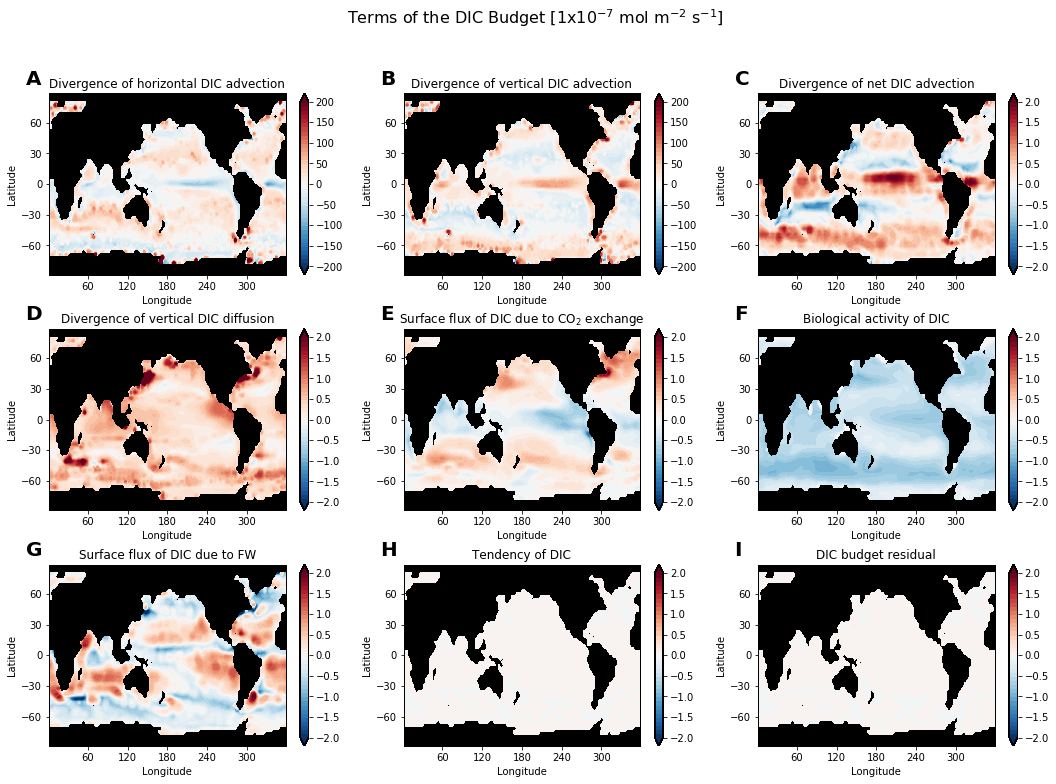

In [ ]:
hdiff_ADV_dic   = xgrid.diff_2d_vector({'X': dicflx.ADVxTr01, 'Y': dicflx.ADVyTr01}, boundary='fill')
dic_adv_horz =-(((hdiff_ADV_dic['X']+hdiff_ADV_dic['Y'])*grid.dzC)/grid.cvol).sel(ZC=slice(0,-kave)).sum("ZC")*grid.cmask.isel(ZC=0)
dic_adv_vert =((xgrid.diff(dicflx.ADVrTr01+kppdiag.KPPgTr01,'Z',boundary='fill')*grid.dzC)/grid.cvol).sel(ZC=slice(0,-kave)).sum("ZC")*grid.cmask.isel(ZC=0)

hdiff_DIF_dic   = xgrid.diff_2d_vector({'X': dicflx.DFxETr01, 'Y': dicflx.DFyETr01}, boundary='fill')
dic_dif_horz =-(((hdiff_DIF_dic['X']+hdiff_DIF_dic['Y'])*grid.dzC)/grid.cvol).sel(ZC=slice(0,-kave)).sum("ZC")*grid.cmask.isel(ZC=0)
dic_dif_vert =((xgrid.diff(dicflx.DFrETr01+dicflx.DFrITr01,'Z',boundary='fill')*grid.dzC)/grid.cvol).sel(ZC=slice(0,-kave)).sum("ZC")*grid.cmask.isel(ZC=0)

# Calculate dissolved inorganic carbon "virtual flux" using salt flux and surface average DIC and S ratios.
#dic_surf_flux= (surfdiag.SFLUX*grid.cmask.isel(ZC=0)/(rhoconst))* \
#                     (xgrid.average(dicflx.TRAC01.isel(ZC=0),['X','Y'])
#                     /xgrid.average(ocediag.SALT.isel(ZC=0),['X','Y']))
dic_surf_flux = dic_surfdiag.DICVCFLX*grid.cmask.isel(ZC=0)
ddicdt       = ((ptracers.dic.diff('T')*grid.dzC).sel(ZC=slice(0,-kave)).sum("ZC")/data_parms['dumpfreq'])*grid.cmask.isel(ZC=0)

# Calculate biological activity terms (mol/m2/s)
dic_bio_flux  = (Rcp*(-dicdiag.DICBIOA+dicdiag.DICPFLUX+dicdiag.DICRDOP)*grid.dzC).sel(ZC=slice(0,-kave)).sum("ZC")*grid.cmask.isel(ZC=0)
dic_carb_flux = ((dicdiag.DICCARB)*grid.dzC).sel(ZC=slice(0,-kave)).sum("ZC")*grid.cmask.isel(ZC=0)

# Air-sea CO2 fluxes
dic_co2_flux = dic_surfdiag.DICCFLX*grid.cmask.isel(ZC=0)

# The budget residual
dic_tot_budget = dic_adv_horz + dic_adv_vert + dic_dif_horz + dic_dif_vert + ddicdt + \
                dic_surf_flux + dic_co2_flux + dic_bio_flux + dic_carb_flux

with warnings.catch_warnings(): # these lines just make sure that the warnings about "mean of empty slice" dont clutter your notebook
    warnings.simplefilter("ignore",category=RuntimeWarning)
    f3,f3ax=plt.subplots(figsize=(18, 12),ncols=3,nrows=3)
    f3.patch.set_facecolor('None')
    f3cax = f3ax.copy()
    f3cbar= f3ax.copy()
    cfac=1e7
    ctargs={"levels":np.arange(-2,2.1,0.1),"cmap":"RdBu_r","extend":"both"}
    ctarg2={"levels":np.arange(-200,210,10),"cmap":"RdBu_r","extend":"both"}
    cbargs={"ticks" :np.arange(-2,2.5,0.5),"extend":"both"}
    cbarg2={"ticks" :np.arange(-200,250,50),"extend":"both"}
    axargs={"xlabel":"Longitude","ylabel":"Latitude","xticks":np.arange(0,420,60),"yticks":np.arange(-90,120,30),"facecolor":"black"}

    f3ax  [0,0].set(title="Divergence of horizontal DIC advection",**axargs)
    f3cax [0,0]=f3ax[0,0].contourf(grid.XC,grid.YC,cfac*dic_adv_horz.mean("T",skipna=True),**ctarg2)
    for a in f3ax[0,0].collections:
        a.set_edgecolor("face")
    f3cbar[0,0]=f3.colorbar(f3cax[0,0],ax=f3ax[0,0],**cbarg2)
    f3cbar[0,0].solids.set_edgecolor("face")
    f3ax  [0,1].set(title="Divergence of vertical DIC advection",**axargs)
    f3cax [0,1]=f3ax[0,1].contourf(grid.XC,grid.YC,cfac*dic_adv_vert.mean("T",skipna=True),**ctarg2)
    for a in f3ax[0,1].collections:
        a.set_edgecolor("face")
    f3cbar[0,1]=f3.colorbar(f3cax[0,1],ax=f3ax[0,1],**cbarg2)
    f3cbar[0,1].solids.set_edgecolor("face")
    f3ax  [0,2].set(title="Divergence of net DIC advection",**axargs)
    f3cax [0,2]=f3ax[0,2].contourf(grid.XC,grid.YC,cfac*(dic_adv_horz+dic_adv_vert).mean("T",skipna=True),**ctargs)
    for a in f3ax[0,2].collections:
        a.set_edgecolor("face")
    f3cbar[0,2]=f3.colorbar(f3cax[0,2],ax=f3ax[0,2],**cbargs)
    f3cbar[0,2].solids.set_edgecolor("face")
    f3ax  [1,0].set(title="Divergence of vertical DIC diffusion",**axargs)
    f3cax [1,0]=f3ax[1,0].contourf(grid.XC,grid.YC,cfac*dic_dif_vert.mean("T",skipna=True),**ctargs)
    for a in f3ax[1,0].collections:
        a.set_edgecolor("face")
    f3cbar[1,0]=f3.colorbar(f3cax[1,0],ax=f3ax[1,0],**cbargs)
    f3cbar[1,0].solids.set_edgecolor("face")
    f3ax  [1,1].set(title="Surface flux of DIC due to CO$_2$ exchange",**axargs)
    f3cax [1,1]=f3ax[1,1].contourf(grid.XC,grid.YC,cfac*dic_co2_flux.mean("T",skipna=True),**ctargs)
    for a in f3ax[1,1].collections:
        a.set_edgecolor("face")
    f3cbar[1,1]=f3.colorbar(f3cax[1,1],ax=f3ax[1,1],**cbargs)
    f3cbar[1,1].solids.set_edgecolor("face")
    f3ax  [1,2].set(title="Biological activity of DIC",**axargs)                     
    f3cax [1,2]=f3ax[1,2].contourf(grid.XC,grid.YC,cfac*(dic_bio_flux+dic_carb_flux).mean("T",skipna=True),**ctargs)
    for a in f3ax[1,2].collections:
        a.set_edgecolor("face")
    f3cbar[1,2]=f3.colorbar(f3cax[1,2],ax=f3ax[1,2],**cbargs)
    f3cbar[1,2].solids.set_edgecolor("face")
    f3ax  [2,0].set(title="Surface flux of DIC due to FW",**axargs)
    f3cax [2,0]=f3ax[2,0].contourf(grid.XC,grid.YC,cfac*dic_surf_flux.mean("T",skipna=True),**ctargs)
    for a in f3ax[2,0].collections:
        a.set_edgecolor("face")
    f3cbar[2,0]=f3.colorbar(f3cax[2,0],ax=f3ax[2,0],**cbargs)
    f3cbar[2,0].solids.set_edgecolor("face")
    f3ax  [2,1].set(title="Tendency of DIC",**axargs)
    f3cax [2,1]=f3ax[2,1].contourf(grid.XC,grid.YC,cfac*ddicdt.mean("T",skipna=True),**ctargs)
    for a in f3ax[2,1].collections:
        a.set_edgecolor("face")
    f3cbar[2,1]=f3.colorbar(f3cax[2,1],ax=f3ax[2,1],**cbargs)
    f3cbar[2,1].solids.set_edgecolor("face")
    f3ax  [2,2].set(title="DIC budget residual",**axargs)
    f3cax [2,2]=f3ax[2,2].contourf(grid.XC,grid.YC,cfac*dic_tot_budget.mean("T",skipna=True),**ctargs)
    for a in f3ax[2,2].collections:
        a.set_edgecolor("face")
    f3cbar[2,2]=f3.colorbar(f3cax[2,2],ax=f3ax[2,2],**cbargs)
    f3cbar[2,2].solids.set_edgecolor("face")
                     
    # Can adjust the subplot size
    f3.subplots_adjust(hspace=0.3) 
    f3.suptitle("Terms of the DIC Budget [1x10$^{-7}$ mol m$^{-2}$ s$^{-1}$]",fontsize=16)
    # add subplot labels (a,b,c,d, etc)
    label_axes(f3ax)


### Phosphate (PO$_4$) Budget
Divergence of P advection, diffusion, biological activity and tendency, time averaged over a year:

#### $$\frac{\partial P}{\partial t}=-\nabla\cdot(\vec{u} P)+\nabla\cdot(\kappa\nabla P) - S_{bio}$$
where $S_{bio}$ is the change in P due to consumption/remineralization of nutrients.

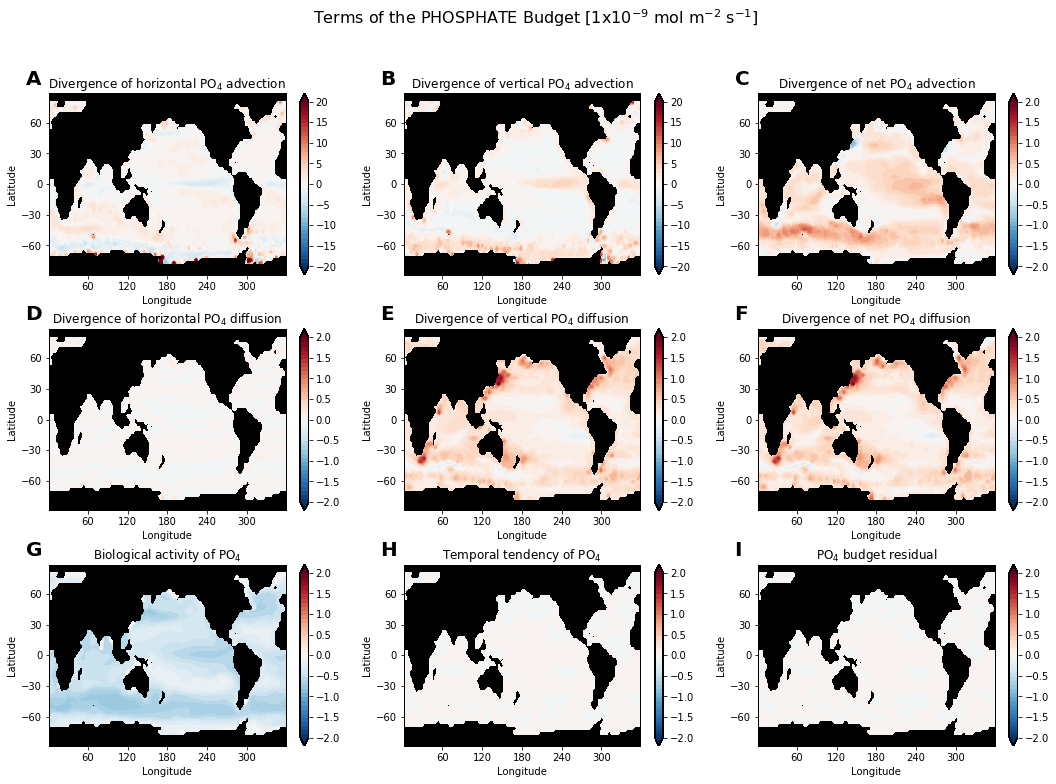

In [ ]:
hdiff_ADV_po4   = xgrid.diff_2d_vector({'X': po4flx.ADVxTr03, 'Y': po4flx.ADVyTr03}, boundary='fill')
po4_adv_horz =-(((hdiff_ADV_po4['X']+hdiff_ADV_po4['Y'])*grid.dzC)/grid.cvol).sel(ZC=slice(0,-kave)).sum("ZC")*grid.cmask.isel(ZC=0)
po4_adv_vert =((xgrid.diff(po4flx.ADVrTr03+kppdiag.KPPgTr03,'Z',boundary='fill')*grid.dzC)/grid.cvol).sel(ZC=slice(0,-kave)).sum("ZC")*grid.cmask.isel(ZC=0)

hdiff_DIF_po4   = xgrid.diff_2d_vector({'X': po4flx.DFxETr03, 'Y': po4flx.DFyETr03}, boundary='fill')
po4_dif_horz =-(((hdiff_DIF_po4['X']+hdiff_DIF_po4['Y'])*grid.dzC)/grid.cvol).sel(ZC=slice(0,-kave)).sum("ZC")*grid.cmask.isel(ZC=0)
po4_dif_vert =((xgrid.diff(po4flx.DFrETr03+po4flx.DFrITr03,'Z',boundary='fill')*grid.dzC)/grid.cvol).sel(ZC=slice(0,-kave)).sum("ZC")*grid.cmask.isel(ZC=0)

dpo4dt       = ((ptracers.po4.diff('T')*grid.dzC).sel(ZC=slice(0,-kave)).sum("ZC")/data_parms['dumpfreq'])*grid.cmask.isel(ZC=0)

# Calculate biological activity terms (mol/m2/s)
po4_bio_flux  = ((-dicdiag.DICBIOA+dicdiag.DICPFLUX+dicdiag.DICRDOP)*grid.dzC).sel(ZC=slice(0,-kave)).sum("ZC")*grid.cmask.isel(ZC=0)

# The budget residual
po4_tot_budget = po4_adv_horz + po4_adv_vert + po4_dif_horz + po4_dif_vert + dpo4dt + po4_bio_flux

with warnings.catch_warnings(): # these lines just make sure that the warnings about "mean of empty slice" dont clutter your notebook
    warnings.simplefilter("ignore",category=RuntimeWarning)
    f4,f4ax=plt.subplots(figsize=(18, 12),ncols=3,nrows=3)
    f4.patch.set_facecolor('None')
    f4cax = f4ax.copy()
    f4cbar= f4ax.copy()
    pfac=1e9
    ctargs={"levels":np.arange(-2,2.1,0.1),"cmap":"RdBu_r","extend":"both"}
    ctarg2={"levels":np.arange(-20,21,1),"cmap":"RdBu_r","extend":"both"}
    cbargs={"ticks" :np.arange(-2,2.5,0.5),"extend":"both"}
    cbarg2={"ticks" :np.arange(-20,25,5),"extend":"both"}
    axargs={"xlabel":"Longitude","ylabel":"Latitude","xticks":np.arange(0,420,60),"yticks":np.arange(-90,120,30),"facecolor":"black"}

    f4ax  [0,0].set(title="Divergence of horizontal PO$_4$ advection",**axargs)
    f4cax [0,0]=f4ax[0,0].contourf(grid.XC,grid.YC,pfac*po4_adv_horz.mean("T",skipna=True),**ctarg2)
    for a in f4ax[0,0].collections:
        a.set_edgecolor("face")
    f4cbar[0,0]=f4.colorbar(f4cax[0,0],ax=f4ax[0,0],**cbarg2)
    f4cbar[0,0].solids.set_edgecolor("face")
    f4ax  [0,1].set(title="Divergence of vertical PO$_4$ advection",**axargs)
    f4cax [0,1]=f4ax[0,1].contourf(grid.XC,grid.YC,pfac*po4_adv_vert.mean("T",skipna=True),**ctarg2)
    for a in f4ax[0,1].collections:
        a.set_edgecolor("face")
    f4cbar[0,1]=f4.colorbar(f4cax[0,1],ax=f4ax[0,1],**cbarg2)
    f4cbar[0,1].solids.set_edgecolor("face")
    f4ax  [0,2].set(title="Divergence of net PO$_4$ advection",**axargs)
    f4cax [0,2]=f4ax[0,2].contourf(grid.XC,grid.YC,pfac*(po4_adv_horz+po4_adv_vert).mean("T",skipna=True),**ctargs)
    for a in f4ax[0,2].collections:
        a.set_edgecolor("face")
    f4cbar[0,2]=f4.colorbar(f4cax[0,2],ax=f4ax[0,2],**cbargs)
    f4cbar[0,2].solids.set_edgecolor("face")
    f4ax  [1,0].set(title="Divergence of horizontal PO$_4$ diffusion",**axargs)
    f4cax [1,0]=f4ax[1,0].contourf(grid.XC,grid.YC,pfac*po4_dif_horz.mean("T",skipna=True),**ctargs)
    for a in f4ax[1,0].collections:
        a.set_edgecolor("face")
    f4cbar[1,0]=f4.colorbar(f4cax[1,0],ax=f4ax[1,0],**cbargs)
    f4cbar[1,0].solids.set_edgecolor("face")
    f4ax  [1,1].set(title="Divergence of vertical PO$_4$ diffusion",**axargs)
    f4cax [1,1]=f4ax[1,1].contourf(grid.XC,grid.YC,pfac*po4_dif_vert.mean("T",skipna=True),**ctargs)
    for a in f4ax[1,1].collections:
        a.set_edgecolor("face")
    f4cbar[1,1]=f4.colorbar(f4cax[1,1],ax=f4ax[1,1],**cbargs)
    f4cbar[1,1].solids.set_edgecolor("face")
    f4ax  [1,2].set(title="Divergence of net PO$_4$ diffusion",**axargs)
    f4cax [1,2]=f4ax[1,2].contourf(grid.XC,grid.YC,pfac*(po4_dif_horz+po4_dif_vert).mean("T",skipna=True),**ctargs)
    for a in f4ax[1,2].collections:
        a.set_edgecolor("face")
    f4cbar[1,2]=f4.colorbar(f4cax[1,2],ax=f4ax[1,2],**cbargs)
    f4cbar[1,2].solids.set_edgecolor("face")
    f4ax  [2,0].set(title="Biological activity of PO$_4$",**axargs)
    f4cax [2,0]=f4ax[2,0].contourf(grid.XC,grid.YC,pfac*po4_bio_flux.mean("T",skipna=True),**ctargs)
    for a in f4ax[2,0].collections:
        a.set_edgecolor("face")
    f4cbar[2,0]=f4.colorbar(f4cax[2,0],ax=f4ax[2,0],**cbargs)
    f4cbar[2,0].solids.set_edgecolor("face")
    f4ax  [2,1].set(title="Temporal tendency of PO$_4$",**axargs)
    f4cax [2,1]=f4ax[2,1].contourf(grid.XC,grid.YC,pfac*dpo4dt.mean("T",skipna=True),**ctargs)
    for a in f4ax[2,1].collections:
        a.set_edgecolor("face")
    f4cbar[2,1]=f4.colorbar(f4cax[2,1],ax=f4ax[2,1],**cbargs)
    f4cbar[2,1].solids.set_edgecolor("face")
    f4ax  [2,2].set(title="PO$_4$ budget residual",**axargs)
    f4cax [2,2]=f4ax[2,2].contourf(grid.XC,grid.YC,pfac*po4_tot_budget.mean("T",skipna=True),**ctargs)
    for a in f4ax[2,2].collections:
        a.set_edgecolor("face")
    f4cbar[2,2]=f4.colorbar(f4cax[2,2],ax=f4ax[2,2],**cbargs)
    f4cbar[2,2].solids.set_edgecolor("face")
                     
    # Can adjust the subplot size
    f4.subplots_adjust(hspace=0.3) 
    f4.suptitle("Terms of the PHOSPHATE Budget [1x10$^{-9}$ mol m$^{-2}$ s$^{-1}$]",fontsize=16)
    # add subplot labels (a,b,c,d, etc)
    label_axes(f4ax)


## CO$_2$ Flux Drivers

First, we are going to work out how temperature, salinity, and alkalinty impact the "saturated" concentration of DIC in seawater. Within the surface mixed layer, DIC concentration can be partitioned into a pool that is in equilibrium with the atmophere, that is, the seawater is saturated, and air-sea pCO$_2$ is in balance, and a pool that is out of equilibrium with the atmosphere:
#### $$C_T=C_{sat}+C_{dis}$$

$C_{sat}$ depends on sea surface temperature, salinity, alkalinity, and pCO$_2$. These relationships can be described assuming a linearization (partitioning) of carbonate chemistry:

#### $$\delta C_{sat}\approx\gamma_{\theta}\delta\theta+\gamma_{S}\delta S+\gamma_{A_T}\delta A_T +\gamma_{pCO_2}\delta pCO_2$$

### Determine solubility coefficients $\gamma_{\theta}$, $\gamma_{S}$, $\gamma_{A_T}$, and $\gamma_{pCO_2}$:

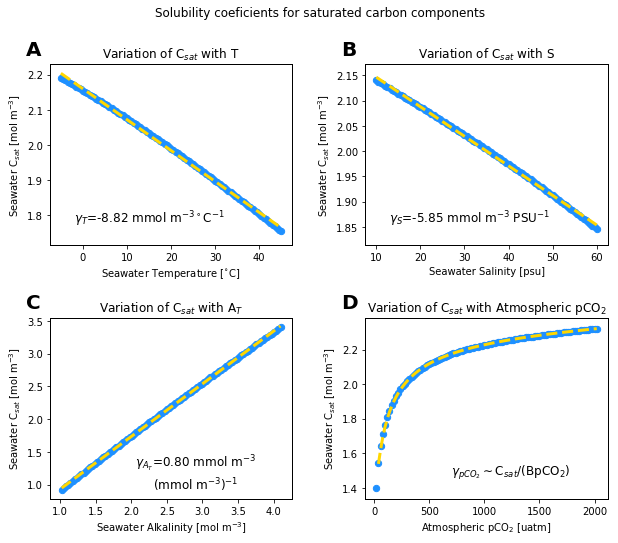

In [ ]:
# use mitgcm_tools.calc_carbon(pco2,alk,po4,sit,theta,salt,pressure)
# it's a wrapper for pyCO2/CO2SYS (https://github.com/seamanticscience/pyCO2)
import co2sys
import scipy.stats  as st

rlen=101

# Define the fixed values
Tfix    = np.ones((rlen,1))*xgrid.average(ocediag.THETA.isel(ZC=0).mean('T'),['X','Y']).values
Sfix    = np.ones((rlen,1))*xgrid.average(ocediag.SALT.isel(ZC=0).mean('T'),['X','Y']).values
Afix    = np.ones((rlen,1))*xgrid.average(alkflx.TRAC02.isel(ZC=0).mean('T'),['X','Y']).values*molperm3_2_umolperkg
Pfix    = np.ones((rlen,1))*xgrid.average(po4flx.TRAC03.isel(ZC=0).mean('T'),['X','Y']).values*molperm3_2_umolperkg
Sifix   = np.ones((rlen,1))*xgrid.average(dic_surfdiag.sit.mean('T'),['X','Y']).values*molperm3_2_umolperkg
Cfix    = np.ones((rlen,1))*atm_box.pco2.mean('T').values*1e6
pressure= np.ones((rlen,1))*-grid.ZC[0].values

# Define the variable ranges
Trange=np.linspace(-5  ,45  ,rlen)[:,np.newaxis]
Srange=np.linspace(10  ,60  ,rlen)[:,np.newaxis]
Arange=np.linspace(1000,4000,rlen)[:,np.newaxis] # in umol/kg
Crange=np.linspace(20  ,2020,rlen)[:,np.newaxis] # in uatm

co=co2sys.calc_co2_system(Sfix, Trange, TA = Afix, pCO2 = Cfix, PO4 = Pfix, Si = Sifix, pres = pressure,
                        K1K2 = "Millero_1995", KBver = "Uppstrom", KSver = "Dickson", KFver = "Dickson", pHScale = 1)
Tvar = co.TC/molperm3_2_umolperkg

co=co2sys.calc_co2_system(Srange, Tfix, TA = Afix, pCO2 = Cfix, PO4 = Pfix, Si = Sifix, pres = pressure,
                        K1K2 = "Millero_1995", KBver = "Uppstrom", KSver = "Dickson", KFver = "Dickson", pHScale = 1)
Svar = co.TC/molperm3_2_umolperkg

co=co2sys.calc_co2_system(Sfix, Tfix, TA = Arange, pCO2 = Cfix, PO4 = Pfix, Si = Sifix, pres = pressure,
                        K1K2 = "Millero_1995", KBver = "Uppstrom", KSver = "Dickson", KFver = "Dickson", pHScale = 1)
Avar = co.TC/molperm3_2_umolperkg

co=co2sys.calc_co2_system(Sfix, Tfix, TA = Afix, pCO2 = Crange, PO4 = Pfix, Si = Sifix, pres = pressure,
                        K1K2 = "Millero_1995", KBver = "Uppstrom", KSver = "Dickson", KFver = "Dickson", pHScale = 1)
Cvar = co.TC/molperm3_2_umolperkg

# regress the results to return the linearized solubility coefficients for T, S, and Alk
Treg = st.linregress(Trange.flatten(),Tvar.flatten())
Sreg = st.linregress(Srange.flatten(),Svar.flatten())
Areg = st.linregress(Arange.flatten()/molperm3_2_umolperkg,Avar.flatten())

gammaT=Treg.slope
gammaS=Sreg.slope
gammaA=Areg.slope

# Csat vs pCO2 is non-linear, can be approximated using the revelle factor
revelle=10 # Typically, the buffer factor ranges between 8 and 13
gC     = Cvar/(revelle*Crange)
gammaC = xr.DataArray(gC.flatten(),coords=[Crange.flatten()], dims=['pCO2'])
dicfit = Cvar+gC*np.mean(np.diff(Crange.flatten()))
Creg   = st.linregress(Cvar[1:].flatten(),dicfit[0:-1].flatten())

# Plot the results
f5,f5ax = plt.subplots(figsize=(10,8),ncols=2,nrows=2)
f5ax[0,0].scatter(Trange,Tvar,s=40,c='dodgerblue')
f5ax[0,0].plot(Trange,Trange*Treg.slope+Treg.intercept,color='gold',linestyle="--",linewidth=3)
f5ax[0,0].set(title="Variation of C$_{{sat}}$ with T",
              xlabel="Seawater Temperature [$^{\circ}$C]",ylabel="Seawater C$_{sat}$ [mol m$^{-3}$]")
f5ax[0,1].scatter(Srange,Svar,s=40,c='dodgerblue')
f5ax[0,1].plot(Srange,Srange*Sreg.slope+Sreg.intercept,color='gold',linestyle="--",linewidth=3)
f5ax[0,1].set(title="Variation of C$_{{sat}}$ with S",
              xlabel="Seawater Salinity [psu]",ylabel="Seawater C$_{sat}$ [mol m$^{-3}$]")
f5ax[1,0].scatter(Arange/molperm3_2_umolperkg,Avar,s=40,c='dodgerblue')
f5ax[1,0].plot(Arange/molperm3_2_umolperkg,(Arange/molperm3_2_umolperkg)*Areg.slope+Areg.intercept,color='gold',linestyle="--",linewidth=3)
f5ax[1,0].set(title="Variation of C$_{{sat}}$ with A$_T$",
              xlabel="Seawater Alkalinity [mol m$^{-3}$]",ylabel="Seawater C$_{sat}$ [mol m$^{-3}$]")
f5ax[1,1].scatter(Crange,Cvar,s=40,c='dodgerblue')
f5ax[1,1].plot(Crange[1:],dicfit[0:-1],color='gold',linestyle="--",linewidth=3)
f5ax[1,1].set(title="Variation of C$_{{sat}}$ with Atmospheric pCO$_2$",
              xlabel="Atmospheric pCO$_2$ [uatm]",ylabel="Seawater C$_{sat}$ [mol m$^{-3}$]")

# Add labels for the coefficient values
f5ax[0,0].text(0.1, 0.15, '$\gamma_{{T}}$={0:.2f} mmol m$^{{-3}}$$^\circ$C$^{{-1}}$'.format(gammaT*1000), horizontalalignment='left',
         verticalalignment='center', transform=f5ax[0,0].transAxes, fontsize=mp.rcParams['axes.titlesize'])
f5ax[0,1].text(0.1, 0.15, '$\gamma_{{S}}$={0:.2f} mmol m$^{{-3}}$ PSU$^{{-1}}$'.format(gammaS*1000), horizontalalignment='left',
         verticalalignment='center', transform=f5ax[0,1].transAxes, fontsize=mp.rcParams['axes.titlesize'])
f5ax[1,0].text(0.6, 0.15, '$\gamma_{{A_T}}$={0:.2f} mmol m$^{{-3}}$\n(mmol m$^{{-3}}$)$^{{-1}}$'.format(gammaA), horizontalalignment='center',
         verticalalignment='center', transform=f5ax[1,0].transAxes, fontsize=mp.rcParams['axes.titlesize'])
f5ax[1,1].text(0.6, 0.15, '$\gamma_{{pCO_2}}\sim$C$_{{sat}}$/(BpCO$_2$)', horizontalalignment='center',
         verticalalignment='center', transform=f5ax[1,1].transAxes, fontsize=mp.rcParams['axes.titlesize'])
f5.suptitle("Solubility coeficients for saturated carbon components")
f5.subplots_adjust(hspace=0.4,wspace=0.3)
# add subplot labels (a,b,c,d, etc)
label_axes(f5ax)


### Diagnosing the drivers of air-sea CO$_2$ fluxes

Returning to the equation for DIC, we can rearrange to solve for the atmoshpere-ocean carbon dioxide flux, integrating the other terms over the upper ocean, $h$:
#### $$F_{CO_2}=\int_{-h}^{0}\left(-\frac{\partial C_T}{\partial t}-\nabla\cdot(\vec{u} C_T)+\nabla\cdot(\kappa\nabla C_T) - \frac{\overline{C_T}F_{fw}}{\rho h} - S_{CaCO_3} - R_{C:P}S_{bio}\right) dz$$
we can partition into saturated/disequilium carbon components,
#### $$F_{CO_2}=\int_{-h}^{0}\left(
      -\frac{\partial \left(C_{sat}+C_{dis}\right)}{\partial t}
      -\nabla\cdot\bigl(\vec{u} \left(C_{sat}+C_{dis}\right)\bigr)
      +\nabla\cdot\bigl(\kappa\nabla \left(C_{sat}+C_{dis}\right)\bigr)
      -\frac{\overline{C_T}F_{fw}}{\rho h} - S_{CaCO_3} - R_{C:P}S_{bio}\right) dz$$
and then attribute changes in C$_{sat}$ to concurrent changes in $\theta$, S, A$_T$, and pCO$_2$,
#### $$\begin{align}
        F_{CO_2}=\int_{-h}^{0}\Biggl(
      &-\frac{\partial \left(\gamma_{\theta}\theta+\gamma_{S}S+\gamma_{A_T}A_T+\gamma_{pCO_2}pCO_2+C_{dis}\right)}{\partial t}\\
      &-\nabla\cdot\bigl(\vec{u} \left(\gamma_{\theta}\theta+\gamma_{S}S+\gamma_{A_T}A_T+\gamma_{pCO_2}pCO_2+C_{dis}\right)\bigr)\\
      &+\nabla\cdot\bigl(\kappa\nabla \left(\gamma_{\theta}\theta+\gamma_{S}S+\gamma_{A_T}A_T+\gamma_{pCO_2}pCO_2+C_{dis}\right)\bigr)\\
      &-\frac{\overline{C_T}F_{fw}}{\rho h} - S_{CaCO_3} - R_{C:P}S_{bio} \Biggr) dz
      \end{align}$$
Rearranging and collecting $\theta$, S, A$_T$, pCO$_2$, and $C_{dis}$ terms gives:
#### $$\begin{align}
        F_{CO_2}=\int_{-h}^{0}\Biggl(
                 &\gamma_{\theta}\left(
                     -\frac{\partial \theta}{\partial t}
                     -\nabla\cdot(\vec{u} \theta)
                     +\nabla\cdot(\kappa\nabla\theta)\right)\\
                +&\gamma_{S}\left(
                     -\frac{\partial S}{\partial t} 
                     -\nabla\cdot(\vec{u} S)
                     +\nabla\cdot(\kappa\nabla S)    \right)\\
                +&\gamma_{A_T}\left(
                     -\frac{\partial A_T}{\partial t}
                     -\nabla\cdot(\vec{u} A_T)
                     +\nabla\cdot(\kappa\nabla A_T)  \right)\\
                +&\gamma_{pCO_2}\left(
                     -\frac{\partial  pCO_2}{\partial t}
                     -\nabla\cdot(\vec{u} pCO_2)  
                     +\nabla\cdot(\kappa\nabla pCO_2)\right)\\
                +& \left(
                     -\frac{\partial C_{dis}}{\partial t}
                     -\nabla\cdot(\vec{u} C_{dis})
                     +\nabla\cdot(\kappa\nabla C_{dis})\right)\\
                -&\frac{\overline{C_T}F_{fw}}{\rho h} - S_{CaCO_3} - R_{C:P}S_{bio} \Biggr) dz
      \end{align}$$
At present, we can neglect oceanic advection and diffusion of saturated carbon due to changes in atmospheric pCO$_2$ because the atmospheric box in the model is well mixed, so by definition will be zero. However, that's not to say that this could contribute to a real-world situation where atmospheric mixing timescale is finite.

Nevertheless, that's still a lot of terms! Here's what that budget looks like, averaged over a year.

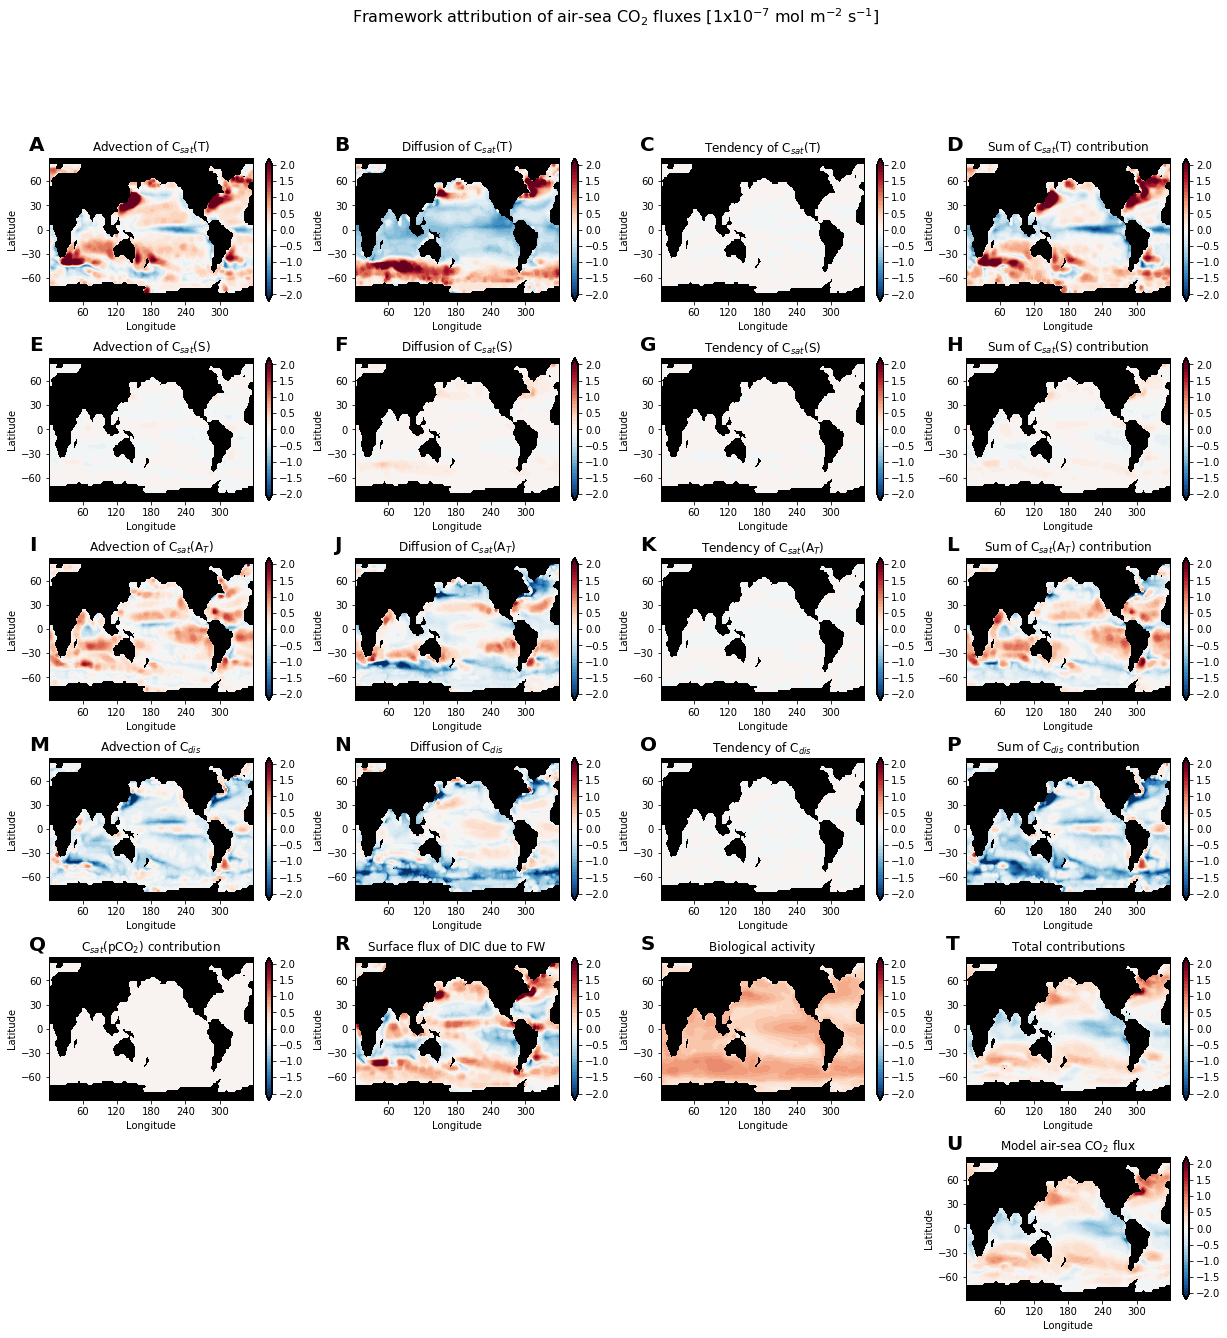

In [ ]:
# Calculate Cdis from the residual DIC-Csat, because there's not a good way of working it out separately
csat_adv_horz=gammaT*theta_adv_horz+gammaS*salt_adv_horz+gammaA*alk_adv_horz
csat_adv_vert=gammaT*theta_adv_vert+gammaS*salt_adv_vert+gammaA*alk_adv_vert
csat_dif_horz=gammaT*theta_dif_horz+gammaS*salt_dif_horz+gammaA*alk_dif_horz
csat_dif_vert=gammaT*theta_dif_vert+gammaS*salt_dif_vert+gammaA*alk_dif_vert

cdis_adv_horz=dic_adv_horz-csat_adv_horz
cdis_adv_vert=dic_adv_vert-csat_adv_vert
cdis_dif_horz=dic_dif_horz-csat_dif_horz
cdis_dif_vert=dic_dif_vert-csat_dif_vert

dcsatdt      = gammaT*dthetadt+gammaS*dsaltdt+gammaA*dalkdt+gammaC.sel(pCO2=atm_box.pco2*1e6,method='nearest')*dpco2dt  
dcdisdt      = ddicdt-dcsatdt

# The budget flux
flux_tot_budget = -gammaT*(theta_adv_horz + theta_adv_vert + theta_dif_horz + theta_dif_vert + dthetadt) +\
                  -gammaS*( salt_adv_horz +  salt_adv_vert +  salt_dif_horz +  salt_dif_vert + dsaltdt ) +\
                  -gammaA*(  alk_adv_horz +   alk_adv_vert +   alk_dif_horz +   alk_dif_vert + dalkdt  ) +\
                       -1*( cdis_adv_horz +  cdis_adv_vert +  cdis_dif_horz +  cdis_dif_vert + dcdisdt ) +\
                 -gammaC.sel(pCO2=atm_box.pco2*1e6,method='nearest')*dpco2dt                            +\
                 -dic_surf_flux - dic_bio_flux - dic_carb_flux

flux_tot_theta=theta_adv_horz + theta_adv_vert + theta_dif_horz + theta_dif_vert + dthetadt
flux_tot_salt = salt_adv_horz +  salt_adv_vert +  salt_dif_horz +  salt_dif_vert + dsaltdt 
flux_tot_alk  =  alk_adv_horz +   alk_adv_vert +   alk_dif_horz +   alk_dif_vert + dalkdt  
flux_tot_cdis = cdis_adv_horz +  cdis_adv_vert +  cdis_dif_horz +  cdis_dif_vert + dcdisdt 

with warnings.catch_warnings(): # these lines just make sure that the warnings about "mean of empty slice" dont clutter your notebook
    warnings.simplefilter("ignore",category=RuntimeWarning)
    f6,f6ax=plt.subplots(figsize=(21, 21),ncols=4,nrows=6)
    f6.patch.set_facecolor('None')
    f6cax = f6ax.copy()
    f6cbar= f6ax.copy()
    cfac=1e7
    ctargs={"levels":np.arange(-2,2.1,0.1),"cmap":"RdBu_r","extend":"both"}
    cbargs={"ticks" :np.arange(-2,2.5,0.5),"extend":"both"}
    axargs={"xlabel":"Longitude","ylabel":"Latitude","xticks":np.arange(0,420,60),"yticks":np.arange(-90,120,30),"facecolor":"black"}

    # Temperature
    f6ax  [0,0].set(title="Advection of C$_{{sat}}$(T)",**axargs)
    f6cax [0,0]=f6ax[0,0].contourf(grid.XC,grid.YC,-cfac*gammaT*(theta_adv_horz+theta_adv_vert).mean("T",skipna=True),**ctargs)
    for a in f6ax[0,0].collections:
        a.set_edgecolor("face")
    f6cbar[0,0]=f6.colorbar(f6cax[0,0],ax=f6ax[0,0],**cbargs)
    f6cbar[0,0].solids.set_edgecolor("face")
    f6ax  [0,1].set(title="Diffusion of C$_{{sat}}$(T)",**axargs)                     
    f6cax [0,1]=f6ax[0,1].contourf(grid.XC,grid.YC,-cfac*gammaT*(theta_dif_vert+theta_dif_vert).mean("T",skipna=True),**ctargs)
    for a in f6ax[0,1].collections:
        a.set_edgecolor("face")
    f6cbar[0,1]=f6.colorbar(f6cax[0,1],ax=f6ax[0,1],**cbargs)
    f6cbar[0,1].solids.set_edgecolor("face")
    f6ax  [0,2].set(title="Tendency of C$_{{sat}}$(T)",**axargs)
    f6cax [0,2]=f6ax[0,2].contourf(grid.XC,grid.YC,-cfac*gammaT*dthetadt.mean("T",skipna=True),**ctargs)
    for a in f6ax[0,2].collections:
        a.set_edgecolor("face")
    f6cbar[0,2]=f6.colorbar(f6cax[0,2],ax=f6ax[0,2],**cbargs)
    f6cbar[0,2].solids.set_edgecolor("face")
    f6ax  [0,3].set(title="Sum of C$_{{sat}}$(T) contribution",**axargs)
    f6cax [0,3]=f6ax[0,3].contourf(grid.XC,grid.YC,-cfac*gammaT*flux_tot_theta.mean("T",skipna=True),**ctargs)
    for a in f6ax[0,3].collections:
        a.set_edgecolor("face")
    f6cbar[0,3]=f6.colorbar(f6cax[0,3],ax=f6ax[0,3],**cbargs)
    f6cbar[0,3].solids.set_edgecolor("face")
                     
    # Salinity
    f6ax  [1,0].set(title="Advection of C$_{{sat}}$(S)",**axargs)
    f6cax [1,0]=f6ax[1,0].contourf(grid.XC,grid.YC,-cfac*gammaS*(salt_adv_horz+salt_adv_vert).mean("T",skipna=True),**ctargs)
    for a in f6ax[1,0].collections:
        a.set_edgecolor("face")
    f6cbar[1,0]=f6.colorbar(f6cax[1,0],ax=f6ax[1,0],**cbargs)
    f6cbar[1,0].solids.set_edgecolor("face")
    f6ax  [1,1].set(title="Diffusion of C$_{{sat}}$(S)",**axargs)
    f6cax [1,1]=f6ax[1,1].contourf(grid.XC,grid.YC,-cfac*gammaS*(salt_dif_vert+salt_dif_vert).mean("T",skipna=True),**ctargs)
    for a in f6ax[1,1].collections:
        a.set_edgecolor("face")
    f6cbar[1,1]=f6.colorbar(f6cax[1,1],ax=f6ax[1,1],**cbargs)
    f6cbar[1,1].solids.set_edgecolor("face")
    f6ax  [1,2].set(title="Tendency of C$_{{sat}}$(S)",**axargs)
    f6cax [1,2]=f6ax[1,2].contourf(grid.XC,grid.YC,-cfac*gammaS*dsaltdt.mean("T",skipna=True),**ctargs)
    for a in f6ax[1,2].collections:
        a.set_edgecolor("face")
    f6cbar[1,2]=f6.colorbar(f6cax[1,2],ax=f6ax[1,2],**cbargs)
    f6cbar[1,2].solids.set_edgecolor("face")
    f6ax  [1,3].set(title="Sum of C$_{{sat}}$(S) contribution",**axargs)
    f6cax [1,3]=f6ax[1,3].contourf(grid.XC,grid.YC,-cfac*gammaT*flux_tot_salt.mean("T",skipna=True),**ctargs)
    for a in f6ax[1,3].collections:
        a.set_edgecolor("face")
    f6cbar[1,3]=f6.colorbar(f6cax[1,3],ax=f6ax[1,3],**cbargs)
    f6cbar[1,3].solids.set_edgecolor("face")
                     
    # Alkalinity
    f6ax  [2,0].set(title="Advection of C$_{{sat}}$(A$_T$)",**axargs)
    f6cax [2,0]=f6ax[2,0].contourf(grid.XC,grid.YC,-cfac*gammaA*(alk_adv_horz+alk_adv_vert).mean("T",skipna=True),**ctargs)
    for a in f6ax[2,0].collections:
        a.set_edgecolor("face")
    f6cbar[2,0]=f6.colorbar(f6cax[2,0],ax=f6ax[2,0],**cbargs)
    f6cbar[2,0].solids.set_edgecolor("face")
    f6ax  [2,1].set(title="Diffusion of C$_{{sat}}$(A$_T$)",**axargs)
    f6cax [2,1]=f6ax[2,1].contourf(grid.XC,grid.YC,-cfac*gammaA*(alk_dif_vert+alk_dif_vert).mean("T",skipna=True),**ctargs)
    for a in f6ax[2,1].collections:
        a.set_edgecolor("face")
    f6cbar[2,1]=f6.colorbar(f6cax[2,1],ax=f6ax[2,1],**cbargs)
    f6cbar[2,1].solids.set_edgecolor("face")
    f6ax  [2,2].set(title="Tendency of C$_{{sat}}$(A$_T$)",**axargs)
    f6cax [2,2]=f6ax[2,2].contourf(grid.XC,grid.YC,-cfac*gammaA*dalkdt.mean("T",skipna=True),**ctargs)
    for a in f6ax[2,2].collections:
        a.set_edgecolor("face")
    f6cbar[2,2]=f6.colorbar(f6cax[2,2],ax=f6ax[2,2],**cbargs)
    f6cbar[2,2].solids.set_edgecolor("face")
    f6ax  [2,3].set(title="Sum of C$_{{sat}}$(A$_T$) contribution",**axargs)
    f6cax [2,3]=f6ax[2,3].contourf(grid.XC,grid.YC,-cfac*gammaA*flux_tot_alk.mean("T",skipna=True),**ctargs)
    for a in f6ax[2,3].collections:
        a.set_edgecolor("face")
    f6cbar[2,3]=f6.colorbar(f6cax[2,3],ax=f6ax[2,3],**cbargs)
    f6cbar[2,3].solids.set_edgecolor("face")
                     
    # Disequilibrium
    f6ax  [3,0].set(title="Advection of C$_{{dis}}$",**axargs)
    f6cax [3,0]=f6ax[3,0].contourf(grid.XC,grid.YC,-cfac*(cdis_adv_horz+cdis_adv_vert).mean("T",skipna=True),**ctargs)
    for a in f6ax[3,0].collections:
        a.set_edgecolor("face")
    f6cbar[3,0]=f6.colorbar(f6cax[3,0],ax=f6ax[3,0],**cbargs)
    f6cbar[3,0].solids.set_edgecolor("face")
    f6ax  [3,1].set(title="Diffusion of C$_{{dis}}$",**axargs)
    f6cax [3,1]=f6ax[3,1].contourf(grid.XC,grid.YC,-cfac*(cdis_dif_vert+cdis_dif_vert).mean("T",skipna=True),**ctargs)
    for a in f6ax[3,1].collections:
        a.set_edgecolor("face")
    f6cbar[3,1]=f6.colorbar(f6cax[3,1],ax=f6ax[3,1],**cbargs)
    f6cbar[3,1].solids.set_edgecolor("face")
    f6ax  [3,2].set(title="Tendency of C$_{{dis}}$",**axargs)
    f6cax [3,2]=f6ax[3,2].contourf(grid.XC,grid.YC,-cfac*dcdisdt.mean("T",skipna=True),**ctargs)
    for a in f6ax[3,2].collections:
        a.set_edgecolor("face")
    f6cbar[3,2]=f6.colorbar(f6cax[3,2],ax=f6ax[3,2],**cbargs)
    f6cbar[3,2].solids.set_edgecolor("face")
    f6ax  [3,3].set(title="Sum of C$_{{dis}}$ contribution",**axargs)
    f6cax [3,3]=f6ax[3,3].contourf(grid.XC,grid.YC,-cfac*flux_tot_cdis.mean("T",skipna=True),**ctargs)
    for a in f6ax[3,3].collections:
        a.set_edgecolor("face")
    f6cbar[3,3]=f6.colorbar(f6cax[3,3],ax=f6ax[3,3],**cbargs)
    f6cbar[3,3].solids.set_edgecolor("face")
                     
    # Other sources and sinks
    f6ax  [4,0].set(title="C$_{{sat}}$(pCO$_2$) contribution",**axargs)
    f6cax [4,0]=f6ax[4,0].contourf(grid.XC,grid.YC,-cfac*(gammaC.sel(pCO2=atm_box.pco2*1e6,method='nearest')*
                                   dpco2dt).mean("T")*grid.cmask.isel(ZC=0).T,**ctargs)
    for a in f6ax[4,0].collections:
        a.set_edgecolor("face")
    f6cbar[4,0]=f6.colorbar(f6cax[4,0],ax=f6ax[4,0],**cbargs)
    f6cbar[4,0].solids.set_edgecolor("face")
    f6ax  [4,1].set(title="Surface flux of DIC due to FW",**axargs)
    f6cax [4,1]=f6ax[4,1].contourf(grid.XC,grid.YC,-cfac*dic_surf_flux.mean("T",skipna=True),**ctargs)
    for a in f6ax[4,1].collections:
        a.set_edgecolor("face")
    f6cbar[4,1]=f6.colorbar(f6cax[4,1],ax=f6ax[4,1],**cbargs)
    f6cbar[4,1].solids.set_edgecolor("face")
    f6ax  [4,2].set(title="Biological activity",**axargs)
    f6cax [4,2]=f6ax[4,2].contourf(grid.XC,grid.YC,-cfac*(dic_bio_flux+dic_carb_flux).mean("T",skipna=True),**ctargs)
    for a in f6ax[4,2].collections:
        a.set_edgecolor("face")
    f6cbar[4,2]=f6.colorbar(f6cax[4,2],ax=f6ax[4,2],**cbargs)
    f6cbar[4,2].solids.set_edgecolor("face")
    f6ax  [4,3].set(title="Total contributions",**axargs)                     
    f6cax [4,3]=f6ax[4,3].contourf(grid.XC,grid.YC,cfac*flux_tot_budget.mean("T",skipna=True),**ctargs)
    for a in f6ax[0,3].collections:
        a.set_edgecolor("face")
    f6cbar[4,3]=f6.colorbar(f6cax[4,3],ax=f6ax[4,3],**cbargs)
    f6cbar[4,3].solids.set_edgecolor("face")
                     
    for ii in np.arange(0,3):
        f6ax[5,ii].axes.get_xaxis().set_visible(False)
        f6ax[5,ii].get_yaxis().set_visible(False)
        f6ax[5,ii].set_facecolor((1,1,1,0))
        f6ax[5,ii].set_axis_off()
    f6ax  [5,3].set(title="Model air-sea CO$_2$ flux",**axargs)
    f6cax [5,3]=f6ax[5,3].contourf(grid.XC,grid.YC,cfac*dic_co2_flux.mean("T",skipna=True), **ctargs)
    for a in f6ax[5,3].collections:
        a.set_edgecolor("face")
    f6cbar[5,3]=f6.colorbar(f6cax[5,3],ax=f6ax[5,3],**cbargs)
    f6cbar[5,3].solids.set_edgecolor("face")
    f6.subplots_adjust(hspace=0.4,wspace=0.2)         
    f6.suptitle("Framework attribution of air-sea CO$_2$ fluxes [1x10$^{-7}$ mol m$^{-2}$ s$^{-1}$]",fontsize=16)
    # add subplot labels (a,b,c,d, etc)
    label_axes(f6ax,ignore=[20,21,22])


The framework reveals that, indeed, we can breakdown the air-sea exchange of CO$_2$ into it's components and begin to attribute the magnitude and direction of the flux. The surface transports of temperature, alkalinity, and "disequilibrium", as well as biological sources and sinks and the effect of precipitation and evaporation on DIC are all of similar magnitude though with different spatial patterns. The Southern Ocean, gyres, western boundary currents, and the Equatorial currents stand out, in particular. The forcing due to salinity transports and the annual-average change in pCO$_2$ is much less significant.

Although this gives us lots of detail, if we wanted to apply our framework to the real ocean, some of these components are very difficult to calculate accurately (such as the diffusive fluxes). Ideally, the air-sea CO$_2$ flux would be expressed as a set of components related to components that are either evaluated operationally or which can be derived from climatologies and ocean state estimates. 

Reconsidering the breakdown of $F_{CO_2}$:
#### $$\begin{align}
        F_{CO_2}=\int_{-h}^{0}\Biggl(
                 &\gamma_{\theta}\left(
                     -\frac{\partial \theta}{\partial t}
                     -\nabla\cdot(\vec{u} \theta)
                     +\nabla\cdot(\kappa\nabla\theta)\right)\\
                +&\gamma_{S}\left(
                     -\frac{\partial S}{\partial t} 
                     -\nabla\cdot(\vec{u} S)
                     +\nabla\cdot(\kappa\nabla S)    \right)\\
                +&\gamma_{A_T}\left(
                     -\frac{\partial A_T}{\partial t}
                     -\nabla\cdot(\vec{u} A_T)
                     +\nabla\cdot(\kappa\nabla A_T)  \right)\\
                +&\gamma_{pCO_2}\left(
                     -\frac{\partial  pCO_2}{\partial t}
                     -\nabla\cdot(\vec{u} pCO_2)  
                     +\nabla\cdot(\kappa\nabla pCO_2)\right)\\
                +& \left(
                     -\frac{\partial C_{dis}}{\partial t}
                     -\nabla\cdot(\vec{u} C_{dis})
                     +\nabla\cdot(\kappa\nabla C_{dis})\right)\\
                -&\frac{\overline{C_T}F_{fw}}{\rho h} - S_{CaCO_3} - R_{C:P}S_{bio} \Biggr) dz
      \end{align}$$
An obvious simplification would be to substitute terms from the $\theta$, S, and A$_T$ budgets:
#### $$\frac{F_\theta}{\rho C_p h}=-\frac{\partial\theta}{\partial t}-\nabla\cdot(\vec{u}\theta)+\nabla\cdot(\kappa\nabla\theta)$$
#### $$\frac{\overline{S}F_{fw}}{\rho h}=-\frac{\partial S}{\partial t}-\nabla\cdot(\vec{u}S)+\nabla\cdot(\kappa\nabla S)$$
#### $$\frac{\overline{A_T}F_{fw}}{\rho  h}=-\frac{\partial A_T}{\partial t} -\nabla\cdot(\vec{u} A_T)+\nabla\cdot(\kappa\nabla A_T)$$
Note that the biological formation of calcium carbonate is not included in the alkalinity equation because of the dominance of freshwater forcing at the surface, which produces a close linear relationship between surface concentrations of alkalinity and salinity. This does not suggest that we totally disregard the small contribution of calcium carbonate cycling in the surface layer, but since C$_{dis}$ is calculated as the residual, DIC-C$_{sat}$, we have instead partitioned it into the C$_{dis}$ pool, consistent with the treatment of the biological fixation of soft tissue carbon, which is also accounted for as part of C$_{dis}$. (Closer inspection of the right-hand column of "net contributions" from $\theta$, S, and A$_T$ could also lead one to the conclusion that this works since biological fluxes of A$_T$ are an order-of-magnitude smaller.)

Similar substitutions can be made, such as reframing biological sources and sinks in terms of the divergence of the nutrient transport:
#### $$S_{bio}=-\frac{\partial P}{\partial t}-\nabla\cdot(\vec{u} P)+\nabla\cdot(\kappa\nabla P)$$
Indeed, for calcium carbonate we could derive a similar expression for the $S_{CaCO3}$ component from the alkalinity equation:
#### $$S_{CaCO_3}=\frac{1}{2}\left(-\frac{\partial A_T}{\partial t}-\nabla\cdot(\vec{u} A_T)+\nabla\cdot(\kappa\nabla A_T) - \frac{\overline{A_T}F_{fw}}{\rho  h} - R_{N:P}S_{bio}\right)$$
For simplicity, however, $S_{CaCO_3}$ can also be estimated by assuming an organic carbon to inorganic carbonate production/remineralization ratio ($R_{CaCO_3}\sim7\%$), in which case:
#### $$S_{CaCO_3} = R_{CaCO_3}R_{CP}S_{bio}$$

Bringing it all together gives us a more concise and more easily applied framework for attributing drivers of the air-sea flux of CO$_2$:
#### $$\begin{align}
        F_{CO_2}=\int_{-h}^{0}\Biggl(
                 &\gamma_{\theta}\frac{F_\theta}{\rho C_p h}
                 +\frac{F_{fw}}{\rho h}\left(\gamma_{S}\overline{S}+\gamma_{A_T}\overline{A_T}-\overline{C_T}\right)
                 -\gamma_{pCO_2}\frac{\partial  pCO_2}{\partial t}\\
                +& \left(
                     -\frac{\partial C_{dis}}{\partial t}
                     -\nabla\cdot(\vec{u} C_{dis})
                     +\nabla\cdot(\kappa\nabla C_{dis})\right)\\
                -&R_{CP}\left(-\frac{\partial P}{\partial t}-\nabla\cdot(\vec{u} P)+\nabla\cdot(\kappa\nabla P)\right)
                        \left(1+R_{CaCO_3}\right)\Biggr) dz
      \end{align}$$

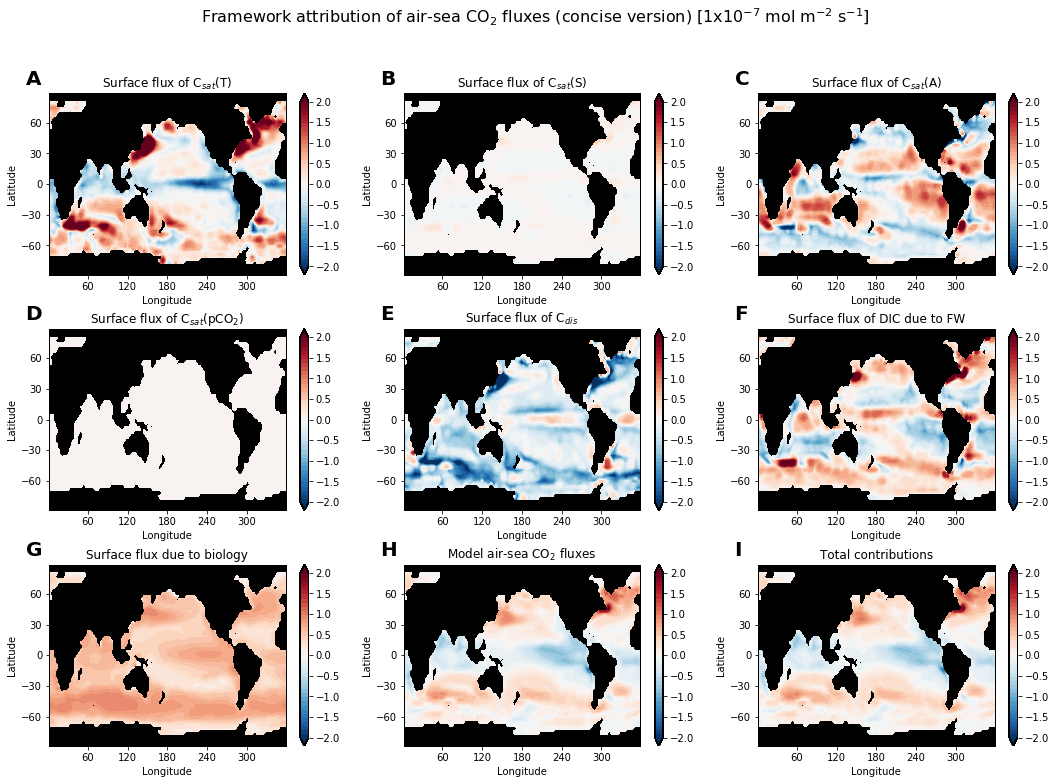

In [ ]:
# Calculate Cdis from the residual DIC-Csat, because there's not a good way of working it out separately
csat_flux_tot=gammaT*theta_surf_flux+gammaS*salt_surf_flux+gammaA*alk_surf_flux-gammaC.sel(pCO2=atm_box.pco2*1e6,method='nearest')*dpco2dt   
cdis_flux_tot=-(dic_adv_horz+dic_adv_vert+dic_dif_horz+dic_dif_vert-ddicdt)-csat_flux_tot
tot_flux_bio =Rcp*(1+Rcaco3)*(po4_adv_horz + po4_adv_vert + po4_dif_horz + po4_dif_vert - dpo4dt)

# The budget flux
flux_tot_budget = csat_flux_tot+cdis_flux_tot+tot_flux_bio-dic_surf_flux
with warnings.catch_warnings(): # these lines just make sure that the warnings about "mean of empty slice" dont clutter your notebook
    warnings.simplefilter("ignore",category=RuntimeWarning)
    f7,f7ax=plt.subplots(figsize=(18, 12),ncols=3,nrows=3)
    f7.patch.set_facecolor('None')
    f7cax = f7ax.copy()
    f7cbar= f7ax.copy()
    cfac=1e7
    ctargs={"levels":np.arange(-2,2.1,0.1),"cmap":"RdBu_r","extend":"both"}
    cbargs={"ticks" :np.arange(-2,2.5,0.5),"extend":"both"}
    axargs={"xlabel":"Longitude","ylabel":"Latitude","xticks":np.arange(0,420,60),"yticks":np.arange(-90,120,30),"facecolor":"black"}
    f7ax  [0,0].set(title="Surface flux of C$_{{sat}}$(T)",**axargs)
    f7cax [0,0]=f7ax[0,0].contourf(grid.XC,grid.YC,cfac*gammaT*theta_surf_flux.mean("T",skipna=True),**ctargs)
    for a in f7ax[0,0].collections:
        a.set_edgecolor("face")
    f7cbar[0,0]=f7.colorbar(f7cax[0,0],ax=f7ax[0,0],**cbargs)
    f7cbar[0,0].solids.set_edgecolor("face")
    f7ax  [0,1].set(title="Surface flux of C$_{{sat}}$(S)",**axargs)                     
    f7cax [0,1]=f7ax[0,1].contourf(grid.XC,grid.YC,cfac*gammaS*salt_surf_flux.mean("T",skipna=True),**ctargs)
    for a in f7ax[0,1].collections:
        a.set_edgecolor("face")
    f7cbar[0,1]=f7.colorbar(f7cax[0,1],ax=f7ax[0,1],**cbargs)
    f7cbar[0,1].solids.set_edgecolor("face")
    f7ax  [0,2].set(title="Surface flux of C$_{{sat}}$(A)",**axargs)
    f7cax [0,2]=f7ax[0,2].contourf(grid.XC,grid.YC,cfac*alk_surf_flux.mean("T",skipna=True),**ctargs)
    for a in f7ax[0,2].collections:
        a.set_edgecolor("face")
    f7cbar[0,2]=f7.colorbar(f7cax[0,2],ax=f7ax[0,2],**cbargs)
    f7cbar[0,2].solids.set_edgecolor("face")
    f7ax  [1,0].set(title="Surface flux of C$_{{sat}}$(pCO$_2$)",**axargs)
    f7cax [1,0]=f7ax[1,0].contourf(grid.XC,grid.YC,-cfac*(gammaC.sel(pCO2=atm_box.pco2*1e6,method='nearest')*
                                                          dpco2dt).mean("T")*grid.cmask.isel(ZC=0).T,**ctargs)
    for a in f7ax[1,0].collections:
        a.set_edgecolor("face")
    f7cbar[1,0]=f7.colorbar(f7cax[1,0],ax=f7ax[1,0],**cbargs)
    f7cbar[1,0].solids.set_edgecolor("face")
    f7ax  [1,1].set(title="Surface flux of C$_{{dis}}$",**axargs)
    f7cax [1,1]=f7ax[1,1].contourf(grid.XC,grid.YC,cfac*cdis_flux_tot.mean("T",skipna=True),**ctargs)
    for a in f7ax[1,1].collections:
        a.set_edgecolor("face")
    f7cbar[1,1]=f7.colorbar(f7cax[1,1],ax=f7ax[1,1],**cbargs)
    f7cbar[1,1].solids.set_edgecolor("face")
    f7ax  [1,2].set(title="Surface flux of DIC due to FW",**axargs)
    f7cax [1,2]=f7ax[1,2].contourf(grid.XC,grid.YC,-cfac*dic_surf_flux.mean("T",skipna=True),**ctargs)
    for a in f7ax[1,2].collections:
        a.set_edgecolor("face")
    f7cbar[1,2]=f7.colorbar(f7cax[1,2],ax=f7ax[1,2],**cbargs)
    f7cbar[1,2].solids.set_edgecolor("face")
    f7ax  [2,0].set(title="Surface flux due to biology",**axargs)
    f7cax [2,0]=f7ax[2,0].contourf(grid.XC,grid.YC,cfac*tot_flux_bio.mean("T",skipna=True),**ctargs)
    for a in f7ax[2,0].collections:
        a.set_edgecolor("face")
    f7cbar[2,0]=f7.colorbar(f7cax[2,0],ax=f7ax[2,0],**cbargs)
    f7cbar[2,0].solids.set_edgecolor("face")
    f7ax  [2,1].set(title="Model air-sea CO$_2$ fluxes",**axargs)
    f7cax [2,1]=f7ax[2,1].contourf(grid.XC,grid.YC,cfac*dic_co2_flux.mean("T",skipna=True),**ctargs)
    for a in f7ax[2,1].collections:
        a.set_edgecolor("face")
    f7cbar[2,1]=f7.colorbar(f7cax[2,1],ax=f7ax[2,1],**cbargs)
    f7cbar[2,1].solids.set_edgecolor("face")
    f7ax  [2,2].set(title="Total contributions",**axargs)
    f7cax [2,2]=f7ax[2,2].contourf(grid.XC,grid.YC,cfac*flux_tot_budget.mean("T",skipna=True),**ctargs)
    for a in f7ax[2,2].collections:
        a.set_edgecolor("face")
    f7cbar[2,2]=f7.colorbar(f7cax[2,2],ax=f7ax[2,2],**cbargs)
    f7cbar[2,2].solids.set_edgecolor("face")
                     
    # Can adjust the subplot size
    f7.subplots_adjust(hspace=0.3) 
    f7.suptitle("Framework attribution of air-sea CO$_2$ fluxes (concise version) [1x10$^{-7}$ mol m$^{-2}$ s$^{-1}$]",fontsize=16)
    # add subplot labels (a,b,c,d, etc)
    label_axes(f7ax)


What about monthly varying fluxes? By including the necessary tendency terms, the framework should hold for timescales when the temporal changes do not average out, say over a seasonal/annual cycle.

In [ ]:
# we're going to animate this! 
month =['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']

# Set up an empty array of labelled axes without contours 
f8,f8ax=plt.subplots(figsize=(16, 12),ncols=3,nrows=3)
f8.patch.set_facecolor('None')
f8cax = f8ax.copy()
f8cbar= f8ax.copy()

def init():
    axargs={"xlabel":"Longitude","ylabel":"Latitude","xticks":np.arange(0,420,60),"yticks":np.arange(-90,120,30),"facecolor":"black"}

    f8ax  [0,0].set(title="Surface flux of C$_{{sat}}$(T)",**axargs)
    f8ax  [0,1].set(title="Surface flux of C$_{{sat}}$(S)",**axargs)
    f8ax  [0,2].set(title="Surface flux of C$_{{sat}}$(A)",**axargs)
    f8ax  [1,0].set(title="Surface flux of C$_{{sat}}$(pCO$_2$)",**axargs)
    f8ax  [1,1].set(title="Surface flux of C$_{{dis}}$",**axargs)
    f8ax  [1,2].set(title="Surface flux of DIC due to FW",**axargs)
    f8ax  [2,0].set(title="Surface flux due to biology",**axargs)
    f8ax  [2,1].set(title="Model air-sea CO$_2$ fluxes",**axargs)
    f8ax  [2,2].set(title="Total contributions",**axargs)

    # Can adjust the subplot size
    f8.subplots_adjust(hspace=0.3) 
    # add subplot labels (a,b,c,d, etc)
    label_axes(f8ax)
    return(f8)
    
def animate(it):
    with warnings.catch_warnings(): # these lines just make sure that the warnings about "mean of empty slice" dont clutter your notebook
        warnings.simplefilter("ignore",category=RuntimeWarning)
        cfac=1e7
        ctargs={"levels":np.arange(-2,2.1,0.1),"cmap":"RdBu_r","extend":"both"}
        cbargs={"ticks" :np.arange(-2,2.5,0.5),"extend":"both"}
        
        f8cax [0,0]=f8ax[0,0].contourf(grid.XC,grid.YC,cfac*gammaT*theta_surf_flux.isel(T=it),**ctargs)
        for a in f8ax[0,0].collections:
            a.set_edgecolor("face")
        #f8cbar[0,0]=f8.colorbar(f8cax[0,0],ax=f8ax[0,0],**cbargs)
        #f8cbar[0,0].solids.set_edgecolor("face")
        f8cax [0,1]=f8ax[0,1].contourf(grid.XC,grid.YC,cfac*gammaS*salt_surf_flux.isel(T=it),**ctargs)
        for a in f8ax[0,1].collections:
            a.set_edgecolor("face")
        #f8cbar[0,1]=f8.colorbar(f8cax[0,1],ax=f8ax[0,1],**cbargs)
        #f8cbar[0,1].solids.set_edgecolor("face")
        
        f8cax [0,2]=f8ax[0,2].contourf(grid.XC,grid.YC,cfac*alk_surf_flux.isel(T=it),**ctargs)
        for a in f8ax[0,2].collections:
            a.set_edgecolor("face")
#        f8cbar[0,2]=f8.colorbar(f8cax[0,2],ax=f8ax[0,2],**cbargs)
#        f8cbar[0,2].solids.set_edgecolor("face")
        
        f8cax [1,0]=f8ax[1,0].contourf(grid.XC,grid.YC,-cfac*(gammaC.sel(pCO2=atm_box.pco2*1e6,method='nearest')*
                                                              dpco2dt).isel(T=it)*grid.cmask.isel(ZC=0).T,**ctargs)
        for a in f8ax[1,0].collections:
            a.set_edgecolor("face")
#        f8cbar[1,0]=f8.colorbar(f8cax[1,0],ax=f8ax[1,0],**cbargs)
#        f8cbar[1,0].solids.set_edgecolor("face")
        
        f8cax [1,1]=f8ax[1,1].contourf(grid.XC,grid.YC,cfac*cdis_flux_tot.isel(T=it),**ctargs)
        for a in f8ax[1,1].collections:
            a.set_edgecolor("face")
#        f8cbar[1,1]=f8.colorbar(f8cax[1,1],ax=f8ax[1,1],**cbargs)
#        f8cbar[1,1].solids.set_edgecolor("face")
        
        f8cax [1,2]=f8ax[1,2].contourf(grid.XC,grid.YC,-cfac*dic_surf_flux.isel(T=it),**ctargs)
        for a in f8ax[1,2].collections:
            a.set_edgecolor("face")
#        f8cbar[1,2]=f8.colorbar(f8cax[1,2],ax=f8ax[1,2],**cbargs)
#        f8cbar[1,2].solids.set_edgecolor("face")
        
        f8cax [2,0]=f8ax[2,0].contourf(grid.XC,grid.YC,cfac*tot_flux_bio.isel(T=it),**ctargs)
        for a in f8ax[2,0].collections:
            a.set_edgecolor("face")
#        f8cbar[2,0]=f8.colorbar(f8cax[2,0],ax=f8ax[2,0],**cbargs)
#        f8cbar[2,0].solids.set_edgecolor("face")
        
        f8cax [2,1]=f8ax[2,1].contourf(grid.XC,grid.YC,cfac*dic_co2_flux.isel(T=it),**ctargs)
        for a in f8ax[2,1].collections:
            a.set_edgecolor("face")
#        f8cbar[2,1]=f8.colorbar(f8cax[2,1],ax=f8ax[2,1],**cbargs)
#        f8cbar[2,1].solids.set_edgecolor("face")
        
        f8cax [2,2]=f8ax[2,2].contourf(grid.XC,grid.YC,cfac*flux_tot_budget.isel(T=it),**ctargs)
        for a in f8ax[2,2].collections:
            a.set_edgecolor("face")
#        f8cbar[2,2]=f8.colorbar(f8cax[2,2],ax=f8ax[2,2],**cbargs)
#        f8cbar[2,2].solids.set_edgecolor("face")
        f8.suptitle("Framework attribution of air-sea CO$_2$ fluxes ("+month[it]+") [1x10$^{-7}$ mol m$^{-2}$ s$^{-1}$]",fontsize=16)
        return f8cax
ani = pla.FuncAnimation(f8, animate, init_func=init, frames=12, interval=250, blit=False)
plt.close(f8)


In [ ]:
ani

We can plot the timeseries of seasonal drivers broken down between different regions that have the same characteristics using the Longhurst province classification.

In [ ]:
# Try a different approach using `regionmask` to get the Longhurst regions
import regionmask
import geopandas

# Open shapefile with geopandas
shp_file_str='Longhurst_world_v4_2010.shp'
tmp = geopandas.read_file(shp_file_str)

# convert from geopandas to regionmask
names   = tmp.ProvDescr.values
abbrevs = tmp.ProvCode.values
numbers = np.arange(len(tmp))
polynoms= tmp['geometry']
ocean_mask = regionmask.Regions(polynoms, numbers, names, abbrevs, name='Longhurst_provinces')
lh_regions = ocean_mask.mask(np.arange(360/256,360,360/128),lat=np.arange(-90+360/256,90,360/128),wrap_lon=True).rename({'lat':'YC','lon':'XC'})

with warnings.catch_warnings(): # these lines just make sure that the warnings about "mean of empty slice" dont clutter your notebook
    warnings.simplefilter("ignore",category=RuntimeWarning)
    ctargs={"levels":np.arange(-2,2.1,0.1),"cmap":"RdBu_r","extend":"both"}
    ax = plt.contourf(grid.XC,grid.YC,lh_regions,levels=np.arange(0,53,1))
    for a in ax.collections:
        a.set_edgecolor("face")
    plt.contour(grid.XC,grid.YC,cfac*dic_co2_flux.mean('T'),levels=np.arange(-2,2.25,0.25),colors='k')
    cbar=plt.colorbar(ax)
    cbar.solids.set_edgecolor("face")
    plt.title("Model air-sea CO$_2$ fluxes\nwith LHR region contours")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.xticks(np.arange(0,420,60))
    plt.yticks(np.arange(-90,120,30))
#    plt.set_facecolor('black')


In [ ]:
# Set up an empty array of labelled axes without contours 
nc=6
nr=10
f10,f10ax=plt.subplots(figsize=(16, 21),ncols=nc,nrows=nr,sharex=True)
f10.patch.set_facecolor('None')
for inr in range(0,nr):
    for inc in range(0,nc):
        if (6*inr+inc)<54:
            #print(6*inr+inc)
            f10ax[inr,inc].plot(xgrid.average(cfac*dic_co2_flux.where(lh_regions==6*inr+inc),{'X','Y'}),color='black',label='Model CO$_2$ flux')
            f10ax[inr,inc].plot(xgrid.average(cfac*flux_tot_budget.where(lh_regions==6*inr+inc),{'X','Y'}),color='black',linestyle='--',label='Budget CO$_2$ flux')
            f10ax[inr,inc].plot(xgrid.average(-cfac*(gammaC.sel(pCO2=atm_box.pco2*1e6,method='nearest')*dpco2dt)*grid.cmask.isel(ZC=0).T
                                             .where(lh_regions==6*inr+inc),{'X','Y'}),color='grey',label='pCO$_2$ Flux')
            f10ax[inr,inc].plot(xgrid.average(cfac*gammaT*theta_surf_flux.where(lh_regions==6*inr+inc),{'X','Y'}),color='red'  ,label='Heat Flux')
            f10ax[inr,inc].plot(xgrid.average(cfac*gammaA*alk_surf_flux.where(lh_regions==6*inr+inc),{'X','Y'}),color='darkviolet',label='Alkalinity FW Flux')
            f10ax[inr,inc].plot(xgrid.average(cfac*gammaS*salt_surf_flux.where(lh_regions==6*inr+inc),{'X','Y'}),color='darkmagenta',label='Salt FW Flux')
            f10ax[inr,inc].plot(xgrid.average(-cfac*dic_surf_flux.where(lh_regions==6*inr+inc),{'X','Y'}),color='rebeccapurple',label='DIC FW Flux')
            f10ax[inr,inc].plot(xgrid.average(cfac*tot_flux_bio.where(lh_regions==6*inr+inc),{'X','Y'}),color='green',label='Biological activity')
            f10ax[inr,inc].plot(xgrid.average(cfac*cdis_flux_tot.where(lh_regions==6*inr+inc),{'X','Y'}),color='teal',label='Disequilibrium Flux')
            f10ax[inr,inc].set(title='LHR#'+np.str(6*inr+inc)+' '+abbrevs[(6*inr+inc)],xlim={0,11}, xticks=np.arange(0,13,1))
            if np.nanmax(np.abs(xgrid.average(cfac*dic_co2_flux.where(lh_regions==6*inr+inc),{'X','Y'})))<0.01:
                f10ax[inr,inc].set(ylim={-0.03,0.03})
            else:
                f10ax[inr,inc].set(ylim={-0.3,0.3})
            #f10ax[inr,inc].set(ylim={-0.3,0.3})

            f10ax[inr,inc].set_xticklabels(month, rotation = 45, horizontalalignment='center')
            if (6*inr+inc) == 52:
                # Legend
                f10ax[inr,inc].legend(loc="lower center",ncol=2,edgecolor='black',
                                     bbox_to_anchor=(0.5,-1.25),bbox_transform=f10ax[inr,inc].transAxes)
        else:
            f10ax[inr,inc].axes.get_xaxis().set_visible(False)
            f10ax[inr,inc].get_yaxis().set_visible(False)
            f10ax[inr,inc].set_facecolor((1,1,1,0))
            f10ax[inr,inc].set_axis_off()
f10.subplots_adjust(hspace=0.4,wspace=0.3)
# add subplot labels (a,b,c,d, etc)
#label_axes(f10ax)